## Import Libraries

In [3]:
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, time, warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV, cross_val_predict
from sklearn.metrics import roc_curve, make_scorer, average_precision_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
import shap
from scipy.stats import wilcoxon, norm, friedmanchisquare
from scipy import stats

# 1. Loading the Data and Early Data Inspection
- Load data
- Early inspection

## Data Loading

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/mystichronicle/online-gaming-behavior-analysis/refs/heads/main/data/online_gaming_behavior_dataset.csv')


In [7]:
print(data.shape)
print(data.dtypes)
print(data.head())

(40034, 13)
PlayerID                       int64
Age                            int64
Gender                        object
Location                      object
GameGenre                     object
PlayTimeHours                float64
InGamePurchases                int64
GameDifficulty                object
SessionsPerWeek                int64
AvgSessionDurationMinutes      int64
PlayerLevel                    int64
AchievementsUnlocked           int64
EngagementLevel               object
dtype: object
   PlayerID  Age  Gender Location GameGenre  PlayTimeHours  InGamePurchases  \
0      9000   43    Male    Other  Strategy      16.271119                0   
1      9001   29  Female      USA  Strategy       5.525961                0   
2      9002   22  Female      USA    Sports       8.223755                0   
3      9003   35    Male      USA    Action       5.265351                1   
4      9004   33    Male   Europe    Action      15.531945                0   

  GameDifficulty  

## Check the distribution of variables

### Numerical variables

In [9]:
# Identify the categorical variables and numerical variables
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
exclude = ['PlayerID', 'InGamePurchases']
numeric_cols = [col for col in numeric_cols if col not in exclude]
print('Categorical:', categorical_cols)
print('Numerical:', numeric_cols)

Categorical: Index(['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel'], dtype='object')
Numerical: ['Age', 'PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked']


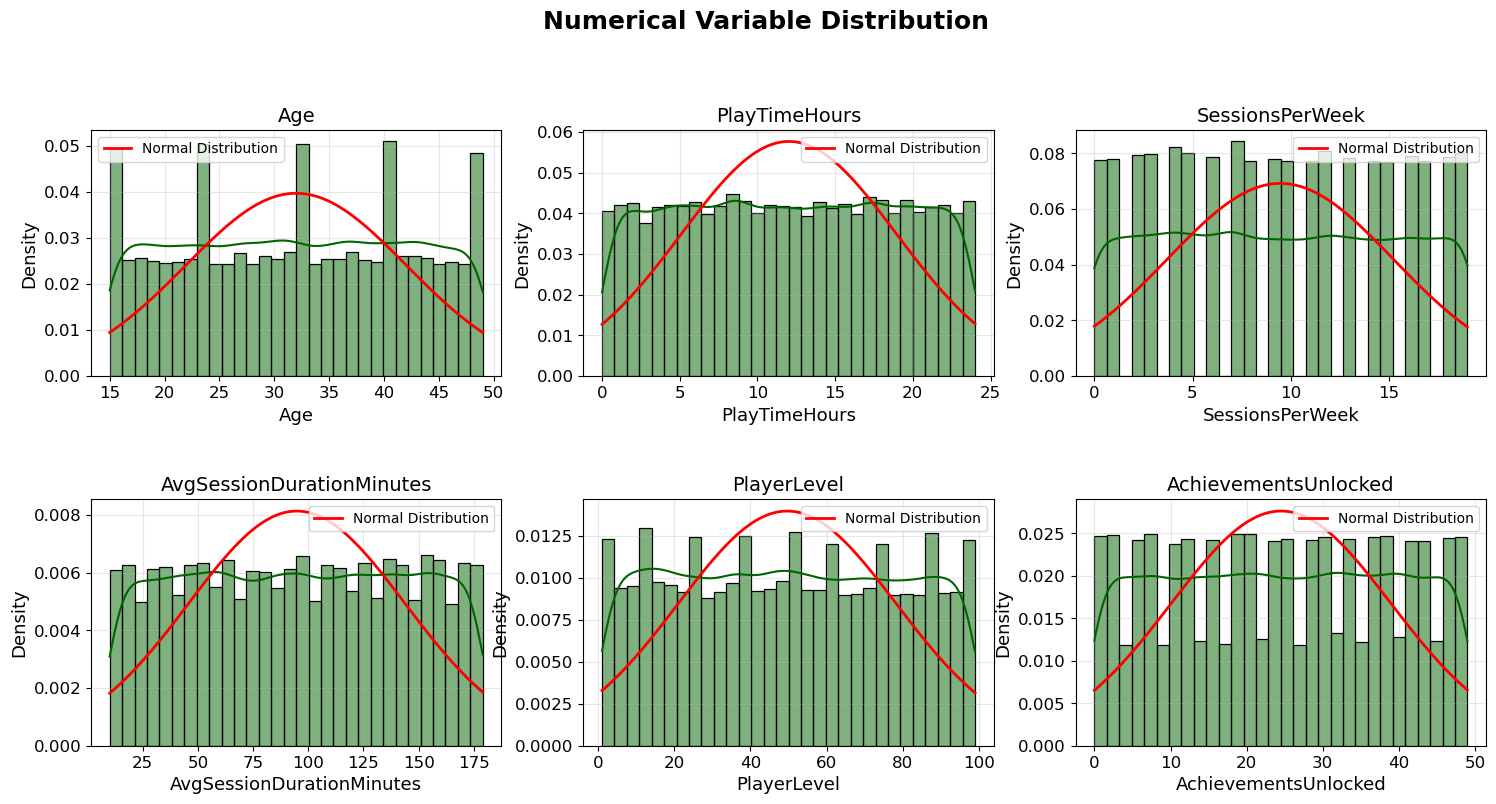

In [45]:
# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
# Flatten axes for easy iteration
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    ax = axes[i]
    # Plot histogram
    sns.histplot(data[col], kde=True, stat='density', bins=30,
                 color='darkgreen', edgecolor='black', ax=ax)
    
    # Normal distribution overlay
    mu, sigma = data[col].mean(), data[col].std()
    x = np.linspace(data[col].min(), data[col].max(), 100)
    ax.plot(x, norm.pdf(x, mu, sigma), color='red', linewidth=2, label='Normal Distribution')
    ax.set_title(f"{col}", fontsize=14)
    ax.set_xlabel(col, fontsize=13)
    ax.set_ylabel('Density', fontsize=13)
    ax.tick_params(axis='both', labelsize=12)
    ax.legend()
    ax.grid(alpha=0.3)

fig.suptitle('Numerical Variable Distribution', fontsize=18, fontweight='bold', y=1.03)
plt.subplots_adjust(hspace=0.5)
plt.savefig('1. Numerical Variable Distribution.png', dpi=500, bbox_inches='tight')
plt.show()

### Categorical variables

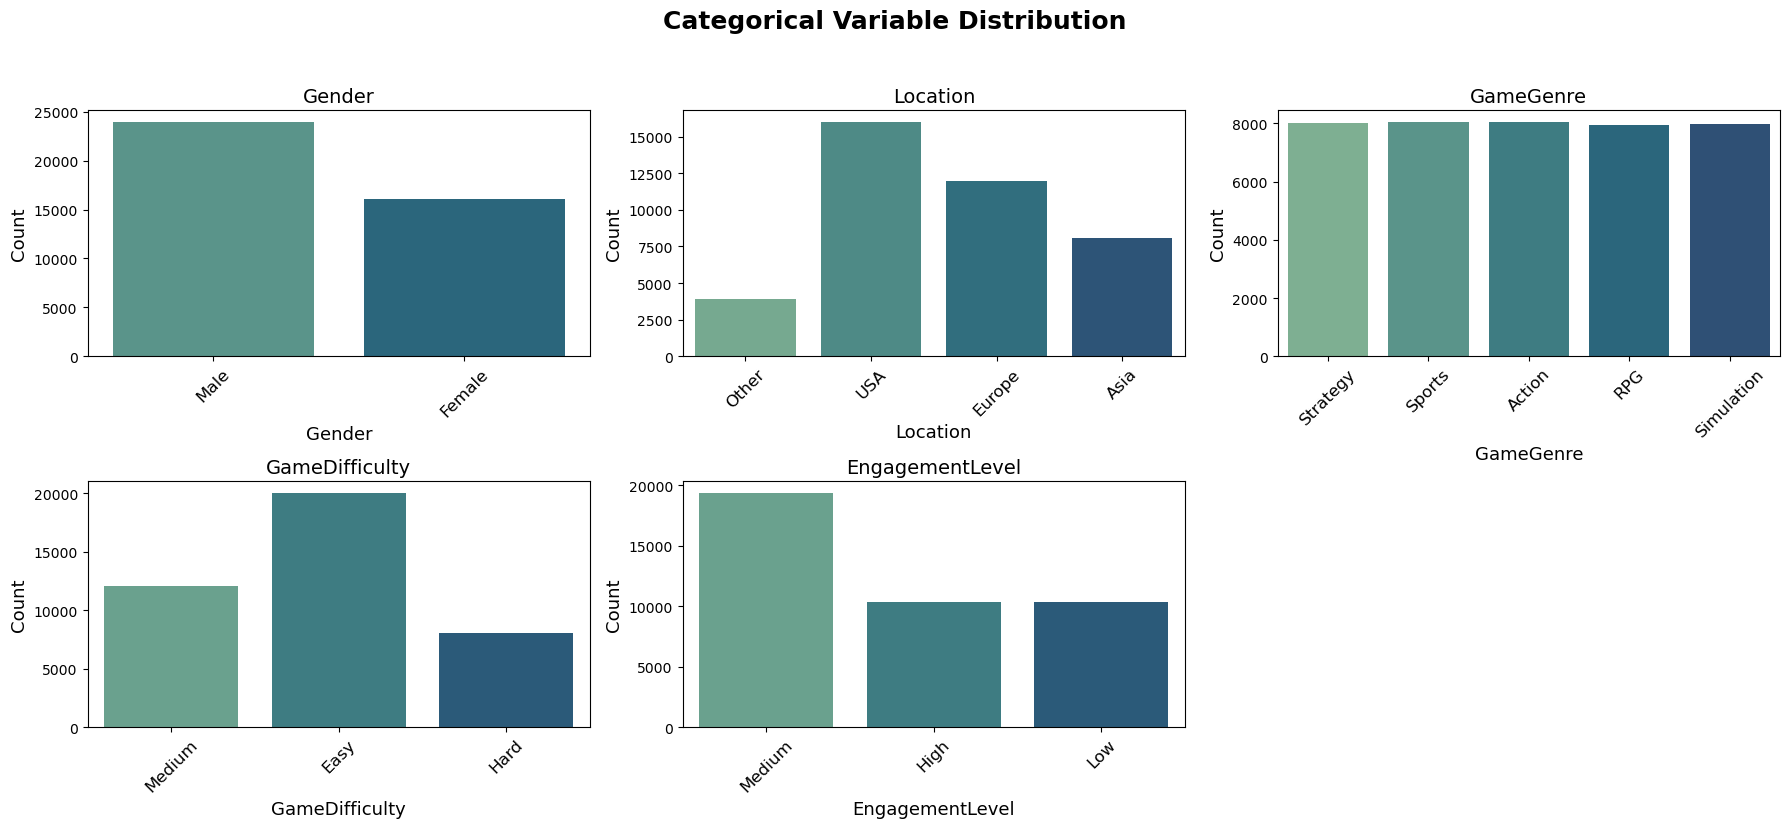

In [53]:
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
plt.subplots_adjust(hspace=0.6)
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.countplot(data=data, x=col, palette='crest', ax=axes[i])
    axes[i].set_title(f"{col}", fontsize=14)
    axes[i].set_xlabel(col, fontsize=13)
    axes[i].set_ylabel('Count', fontsize=13)
    axes[i].tick_params(axis='x', rotation=45, labelsize=12)
    
if len(categorical_cols) < len(axes):
    axes[-1].axis('off')

fig.suptitle('Categorical Variable Distribution', fontsize=18, fontweight='bold', y=1.03)
plt.savefig('2. Categorical Variable Distribution.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

In [13]:
for var in categorical_cols:
    print(data[var].value_counts(normalize = True) * 100)
    print ('=========================')

Gender
Male      59.84663
Female    40.15337
Name: proportion, dtype: float64
Location
USA       39.966029
Europe    29.984513
Asia      20.220313
Other      9.829145
Name: proportion, dtype: float64
GameGenre
Sports        20.102913
Action        20.080432
Strategy      20.012989
Simulation    19.940551
RPG           19.863116
Name: proportion, dtype: float64
GameDifficulty
Easy      49.995004
Medium    30.001998
Hard      20.002997
Name: proportion, dtype: float64
EngagementLevel
Medium    48.393865
High      25.818055
Low       25.788080
Name: proportion, dtype: float64


### Target Variable Distribution

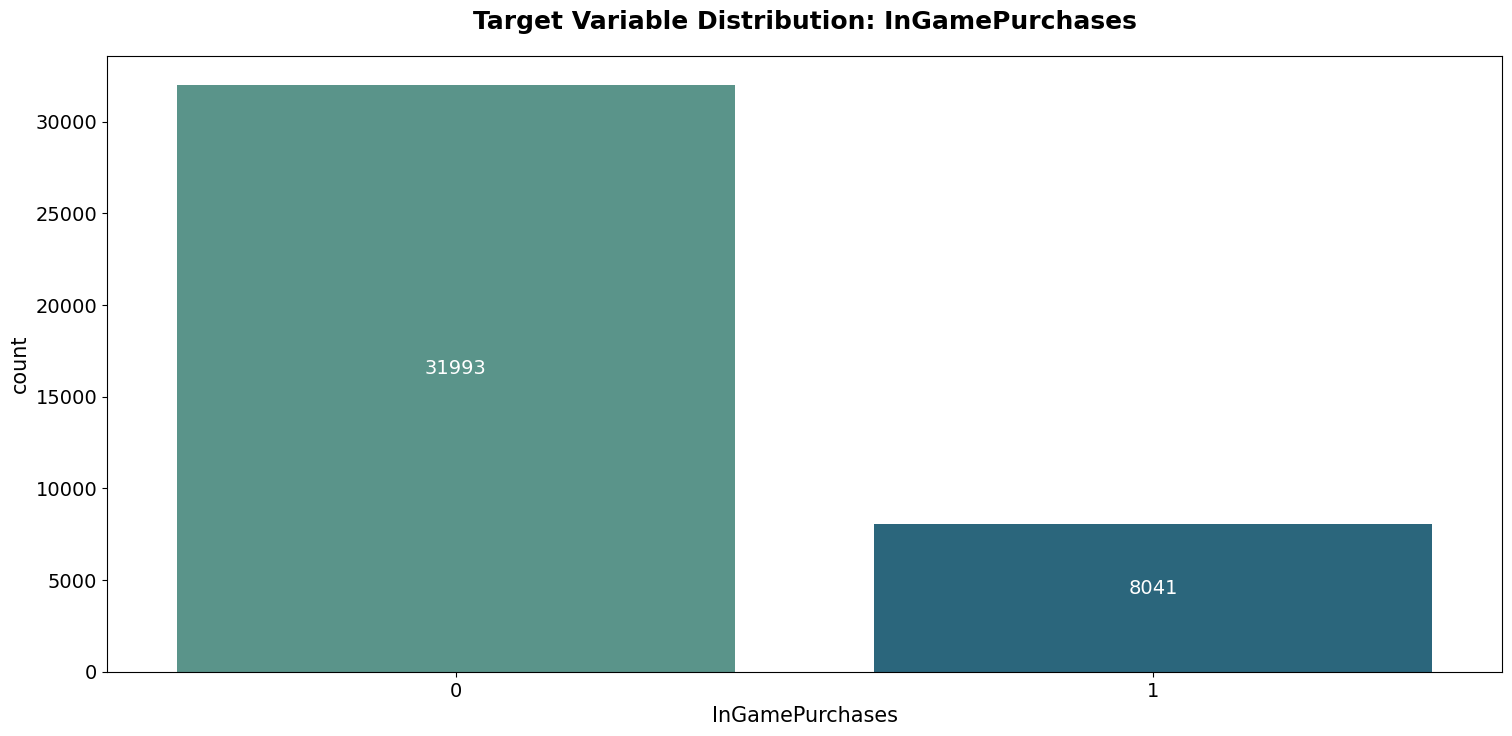

InGamePurchases
0    79.914573
1    20.085427
Name: proportion, dtype: float64


In [63]:
# Detect Imbalance in Target Variable
plt.figure(figsize=(18,8))
ax = sns.countplot(data=data, x='InGamePurchases', palette='crest')
for p in ax.patches:
    count = int(p.get_height())
    ax.text(p.get_x() + p.get_width() / 2., p.get_height() * 0.5, count,
            ha='center', va='bottom', fontsize=14, color='white', family='sans-serif')
    ax.xaxis.label.set_size(15)
    ax.yaxis.label.set_size(15)
    ax.tick_params(axis='both', labelsize=14)
plt.title('Target Variable Distribution: InGamePurchases', fontsize=18, fontweight='bold', y=1.03)
plt.savefig('3. Target Variable Distribution.png', dpi=500, bbox_inches='tight')
plt.show()

print(data['InGamePurchases'].value_counts(normalize=True) * 100)

<div class="alert alert-info">=====================</div>

# 2. Data Preprocessing
Detect and manage 
- Duplicates
- Missing value
- Outliers
- Noise (negative values within numerical variables)
- Highly skewed variables

## 2.1 Manage Duplicates

In [19]:
# Check for duplicate rows
duplicates = data.duplicated()

# Count number of duplicate rows
num_duplicates = duplicates.sum()
print(f'Number of duplicated rows: {num_duplicates}')

Number of duplicated rows: 0


## 2.2 Manage Missing values

In [21]:
# Check missing values in each variable of data
print(data.isnull().sum())

PlayerID                     0
Age                          0
Gender                       0
Location                     0
GameGenre                    0
PlayTimeHours                0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
PlayerLevel                  0
AchievementsUnlocked         0
EngagementLevel              0
dtype: int64


## 2.3 Manage Outliers

In [23]:
# Outlier spotting out by IQR Method
outlier_dict = {}

for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    outlier_dict[col] = len(outliers)

print('Outliers per feature (IQR method):\n', outlier_dict)

Outliers per feature (IQR method):
 {'Age': 0, 'PlayTimeHours': 0, 'SessionsPerWeek': 0, 'AvgSessionDurationMinutes': 0, 'PlayerLevel': 0, 'AchievementsUnlocked': 0}


In [24]:
# Double check with Z-Score
from scipy.stats import zscore

z_scores = zscore(data[numeric_cols])
outliers = (abs(z_scores) > 3)

# Count outliers per column
outlier_counts = outliers.sum(axis=0)
print('Outliers per feature:\n', dict(zip(numeric_cols, outlier_counts)))

Outliers per feature:
 {'Age': 0, 'PlayTimeHours': 0, 'SessionsPerWeek': 0, 'AvgSessionDurationMinutes': 0, 'PlayerLevel': 0, 'AchievementsUnlocked': 0}


## 2.4 Manage Noise

In [26]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
PlayerID,40034.0,29016.500000,11556.964675,9000.000000,19008.250000,29016.500000,39024.750000,49033.000000
Age,40034.0,31.992531,10.043227,15.000000,23.000000,32.000000,41.000000,49.000000
PlayTimeHours,40034.0,12.024365,6.914638,0.000115,6.067501,12.008002,17.963831,23.999592
InGamePurchases,40034.0,0.200854,0.400644,0.000000,0.000000,0.000000,0.000000,1.000000
SessionsPerWeek,40034.0,9.471774,5.763667,0.000000,4.000000,9.000000,14.000000,19.000000
AvgSessionDurationMinutes,40034.0,94.792252,49.011375,10.000000,52.000000,95.000000,137.000000,179.000000
PlayerLevel,40034.0,49.655568,28.588379,1.000000,25.000000,49.000000,74.000000,99.000000
AchievementsUnlocked,40034.0,24.526477,14.430726,0.000000,12.000000,25.000000,37.000000,49.000000


In [27]:
data.describe(include='object').T

,count,unique,top,freq
Gender,40034,2,Male,23959
Location,40034,4,USA,16000
GameGenre,40034,5,Sports,8048
GameDifficulty,40034,3,Easy,20015
EngagementLevel,40034,3,Medium,19374


## 2.5 Manage Highly Skewed

In [29]:
# Skewness for all numeric features
skew_values = data[numeric_cols].skew()
print('Skewness of Numeric Variables:\n')
print(skew_values)

Skewness of Numeric Variables:

Age                         -0.004466
PlayTimeHours               -0.002225
SessionsPerWeek              0.015517
AvgSessionDurationMinutes   -0.005632
PlayerLevel                  0.018754
AchievementsUnlocked        -0.005136
dtype: float64


<div class="alert alert-info">=====================</div>

# 3. Splitting the Dataset

In [65]:
# Create copy version of dataset
data_engineer = data.copy()
print(data_engineer.columns.tolist())

['PlayerID', 'Age', 'Gender', 'Location', 'GameGenre', 'PlayTimeHours', 'InGamePurchases', 'GameDifficulty', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked', 'EngagementLevel']


In [67]:
## turn 'Age' into categorical feature based on the marketing age band and then encoding
# Define bins and labels
bins = [0, 17, 24, 34, 44, 54]
labels = ['Teen', 'Young Adult', 'Adult', 'Mid-Age', 'Mature']

# Create a new categorical column
data_engineer['AgeGroup'] = pd.cut(data_engineer['Age'], bins=bins, labels=labels, right=True)
data_engineer = data_engineer.drop(columns=['Age'])
print (data_engineer.head())

   PlayerID  Gender Location GameGenre  PlayTimeHours  InGamePurchases  \
0      9000    Male    Other  Strategy      16.271119                0   
1      9001  Female      USA  Strategy       5.525961                0   
2      9002  Female      USA    Sports       8.223755                0   
3      9003    Male      USA    Action       5.265351                1   
4      9004    Male   Europe    Action      15.531945                0   

  GameDifficulty  SessionsPerWeek  AvgSessionDurationMinutes  PlayerLevel  \
0         Medium                6                        108           79   
1         Medium                5                        144           11   
2           Easy               16                        142           35   
3           Easy                9                         85           57   
4         Medium                2                        131           95   

   AchievementsUnlocked EngagementLevel     AgeGroup  
0                    25          Medi

In [69]:
# Define the target variables
X = data_engineer.drop(columns=['InGamePurchases', 'PlayerID'])
y = data_engineer['InGamePurchases']


# Split your data with 20% data randomly assigning for the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)

print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)
print (X_train.head())
print(X_train.columns.tolist())
print(X_test.columns.tolist())

(32027, 11)
(8007, 11)
(32027,)
(8007,)
       Gender Location GameGenre  PlayTimeHours GameDifficulty  \
6328     Male     Asia    Action      23.060141           Easy   
31028    Male      USA  Strategy      10.266828           Easy   
28807  Female      USA  Strategy      10.592528           Hard   
1534     Male      USA  Strategy      11.079337         Medium   
1994     Male      USA  Strategy      22.604658           Easy   

       SessionsPerWeek  AvgSessionDurationMinutes  PlayerLevel  \
6328                11                        117           38   
31028                3                         66           68   
28807               19                        145           96   
1534                 6                        154           70   
1994                15                         79           57   

       AchievementsUnlocked EngagementLevel AgeGroup  
6328                     24             Low    Adult  
31028                     6             Low    Adult  
2

<div class="alert alert-info">=====================</div>

# 4. Feature Preparation
- Feature Engineering: label-encoded for categorical variables and normalization for numerical variables
- Feature Selection: Mutual Information

## Feature Engineering

### Categorical Variable Encoding

In [71]:
categorical_engineer = data_engineer.select_dtypes(include=['object', 'category']).columns
print('Categorical:', categorical_engineer)

Categorical: Index(['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel',
       'AgeGroup'],
      dtype='object')


In [73]:
# Gender
encoder_gender = LabelEncoder()
X_train['Gender'] = encoder_gender.fit_transform(X_train['Gender'])
X_test['Gender'] = encoder_gender.transform(X_test['Gender'])

# Location
encoder_location = LabelEncoder()
X_train['Location'] = encoder_location.fit_transform(X_train['Location'])
X_test['Location'] = encoder_location.transform(X_test['Location'])

# GameGenre
encoder_game = LabelEncoder()
X_train['GameGenre'] = encoder_game.fit_transform(X_train['GameGenre'])
X_test['GameGenre'] = encoder_game.transform(X_test['GameGenre'])

# Game Difficulty
encoder_diff = LabelEncoder()
X_train['GameDifficulty'] = encoder_diff.fit_transform(X_train['GameDifficulty'])
X_test['GameDifficulty'] = encoder_diff.transform(X_test['GameDifficulty'])

# Engagement Level
encoder_eng = LabelEncoder()
X_train['EngagementLevel'] = encoder_eng.fit_transform(X_train['EngagementLevel'])
X_test['EngagementLevel'] = encoder_eng.transform(X_test['EngagementLevel'])

# Age Group
encoder_age = LabelEncoder()
X_train['AgeGroup'] = encoder_age.fit_transform(X_train['AgeGroup'])
X_test['AgeGroup'] = encoder_age.transform(X_test['AgeGroup'])

### Numerical Variables Normalization

In [76]:
print('Numerical:', numeric_cols)

Numerical: ['Age', 'PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked']


In [78]:
# PlayTimeHours
scaler_hours = MinMaxScaler()
X_train['PlayTimeHours'] = scaler_hours.fit_transform(X_train[['PlayTimeHours']])
X_test['PlayTimeHours'] = scaler_hours.transform(X_test[['PlayTimeHours']])

# SessionsPerWeek
scaler_session = MinMaxScaler()
X_train['SessionsPerWeek'] = scaler_session.fit_transform(X_train[['SessionsPerWeek']])
X_test['SessionsPerWeek'] = scaler_session.transform(X_test[['SessionsPerWeek']])

# AvgSessionDurationMinutes
scaler_aveDuration = MinMaxScaler()
X_train['AvgSessionDurationMinutes'] = scaler_aveDuration.fit_transform(X_train[['AvgSessionDurationMinutes']])
X_test['AvgSessionDurationMinutes'] = scaler_aveDuration.transform(X_test[['AvgSessionDurationMinutes']])

# PlayerLevel
scaler_player = MinMaxScaler()
X_train['PlayerLevel'] = scaler_player.fit_transform(X_train[['PlayerLevel']])
X_test['PlayerLevel'] = scaler_player.transform(X_test[['PlayerLevel']])

# AchievementsUnlocked
scaler_achieve = MinMaxScaler()
X_train['AchievementsUnlocked'] = scaler_achieve.fit_transform(X_train[['AchievementsUnlocked']])
X_test['AchievementsUnlocked'] = scaler_achieve.transform(X_test[['AchievementsUnlocked']])

### Feature Selection

#### Correlation matrix

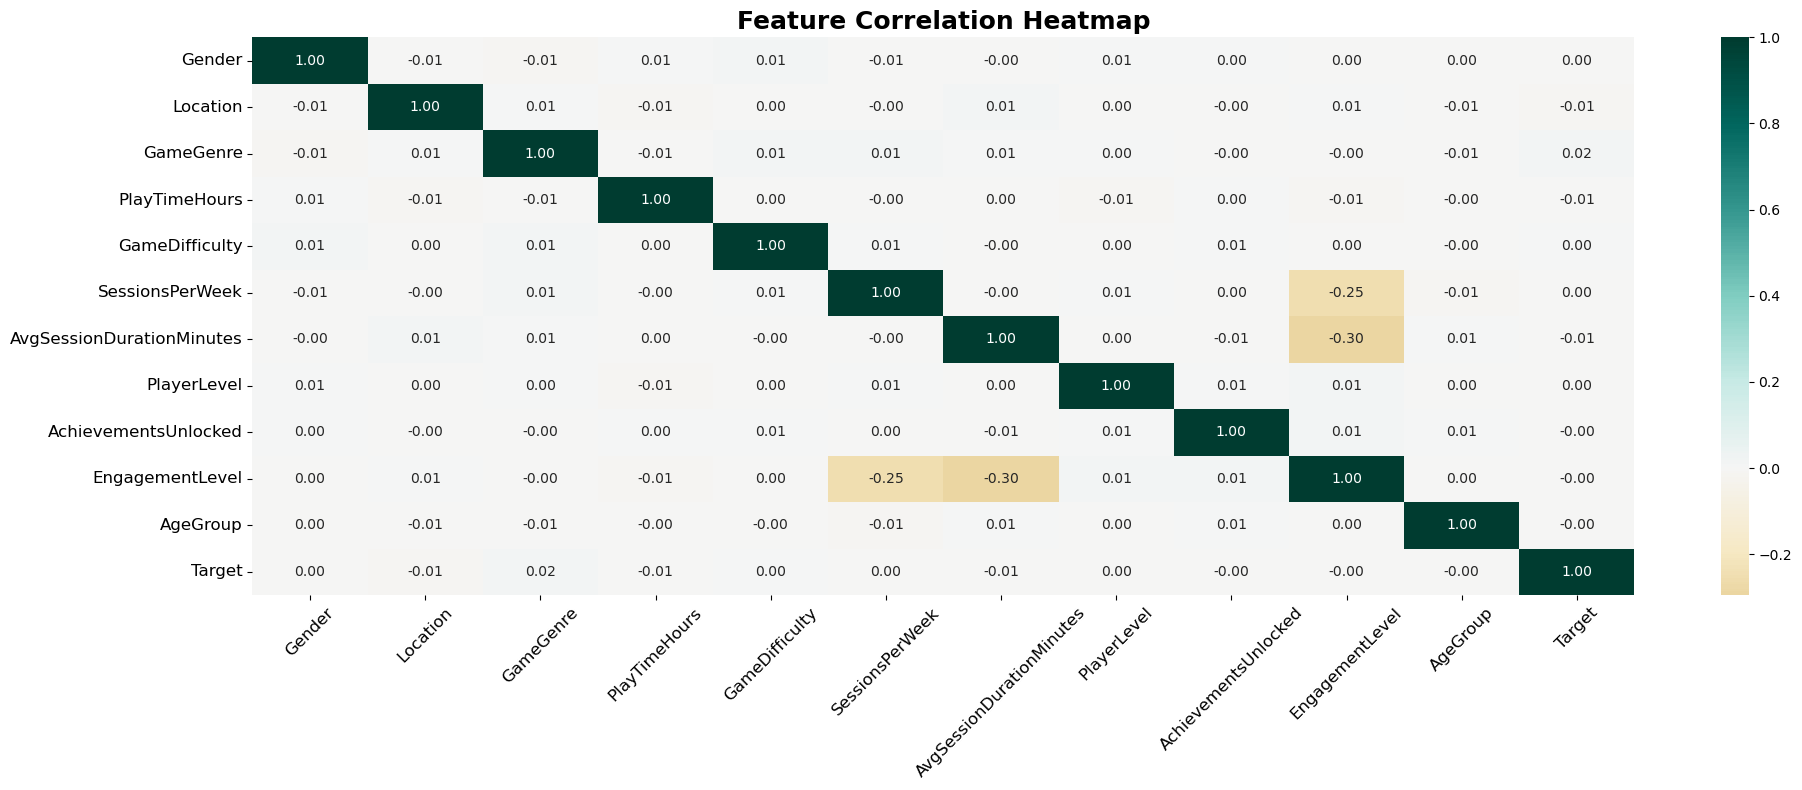

In [90]:
# Combine again featurew and target
corr_data = X_train.copy()
corr_data['Target'] = y_train

corr_matrix = corr_data.corr(numeric_only=True)

plt.figure(figsize=(20, 8))
ax = sns.heatmap(
    corr_matrix,
    cmap='BrBG',
    center=0,
    annot=True,
    fmt='.2f',
    annot_kws={"size": 10}
)

ax.tick_params(axis='x', labelsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)
plt.title('Feature Correlation Heatmap', fontsize=18, weight='bold')
plt.tight_layout()
plt.savefig('4. Feature Correlation.png', dpi=500, bbox_inches='tight')
plt.show()

#### Mutual Information

In [92]:
# Compute mutual information scores on training data
mi_scores = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=23)

# Create a ranked DataFrame of features
mi_rank = pd.DataFrame({'Feature': X_train.columns, 'MI Score': mi_scores})
mi_rank.sort_values(by='MI Score', ascending=False, inplace=True)

# Preview top features
print('Top features by Mutual Information:')
print(mi_rank)

Top features by Mutual Information:
                      Feature  MI Score
4              GameDifficulty  0.003529
1                    Location  0.003349
8        AchievementsUnlocked  0.002843
0                      Gender  0.001515
9             EngagementLevel  0.000614
5             SessionsPerWeek  0.000261
10                   AgeGroup  0.000198
2                   GameGenre  0.000000
3               PlayTimeHours  0.000000
6   AvgSessionDurationMinutes  0.000000
7                 PlayerLevel  0.000000


#### Feature selected based on MI

In [94]:
# Feature selection
selected_features = mi_rank[mi_rank['MI Score'] > 0]['Feature'].tolist()
X_train_selected = X_train[selected_features]
print (X_train_selected.head())

       GameDifficulty  Location  AchievementsUnlocked  Gender  \
6328                0         0              0.489796       1   
31028               0         3              0.122449       1   
28807               1         3              0.387755       0   
1534                2         3              0.959184       1   
1994                0         3              0.163265       1   

       EngagementLevel  SessionsPerWeek  AgeGroup  
6328                 1         0.578947         0  
31028                1         0.157895         0  
28807                0         1.000000         2  
1534                 2         0.315789         1  
1994                 2         0.789474         2  


In [95]:
X_test_selected = X_test[selected_features]
print (X_test_selected.head())

       GameDifficulty  Location  AchievementsUnlocked  Gender  \
24140               0         3              0.469388       0   
17129               0         3              0.938776       1   
4776                0         3              0.612245       0   
35035               2         1              0.000000       1   
3297                0         1              0.612245       1   

       EngagementLevel  SessionsPerWeek  AgeGroup  
24140                2         1.000000         0  
17129                2         0.263158         1  
4776                 0         1.000000         0  
35035                2         0.421053         2  
3297                 2         0.210526         4  


In [99]:
print('Categorical:', categorical_cols)
cat_list_selected = []
for x in categorical_cols:
    if x in selected_features:
        cat_list_selected.append(x)
cat_list_selected.append('AgeGroup')
print('Selected categorical features:',cat_list_selected)

Categorical: Index(['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'EngagementLevel'], dtype='object')
Selected categorical features: ['Gender', 'Location', 'GameDifficulty', 'EngagementLevel', 'AgeGroup']


In [101]:
print('Numerical:', numeric_cols)
print('Selected features:', selected_features)
num_list_selected = []
for x in numeric_cols:
    if x in selected_features:
        num_list_selected.append(x)
print('Selected numerical features:',num_list_selected)

Numerical: ['Age', 'PlayTimeHours', 'SessionsPerWeek', 'AvgSessionDurationMinutes', 'PlayerLevel', 'AchievementsUnlocked']
Selected features: ['GameDifficulty', 'Location', 'AchievementsUnlocked', 'Gender', 'EngagementLevel', 'SessionsPerWeek', 'AgeGroup']
Selected numerical features: ['SessionsPerWeek', 'AchievementsUnlocked']


<div class="alert alert-info">=====================</div>

# 5. Configuration Selection
- Create different configuration
- Find the best configuration (no tuning)

## Create different configuration

In [57]:
print(X_train_selected.columns.tolist())

['GameDifficulty', 'Location', 'AchievementsUnlocked', 'Gender', 'EngagementLevel', 'SessionsPerWeek', 'AgeGroup']


In [103]:
# Create Demographic set and In-game behaviour training set
X_train_demo = X_train_selected[['Location', 'Gender','AgeGroup']]
X_train_game = X_train_selected[['GameDifficulty', 'AchievementsUnlocked','EngagementLevel','SessionsPerWeek']]
print(X_train_demo.columns.tolist())
print(X_train_game.columns.tolist())

['Location', 'Gender', 'AgeGroup']
['GameDifficulty', 'AchievementsUnlocked', 'EngagementLevel', 'SessionsPerWeek']


## Find the best configuration
- Linear Regression, Random Forest, XGBoost, CatBoost
- Cross-Validation with stratification 5-folds
- with Evaluation metrics (as PR-AUC as the primary metric, precision, recall, and F1)
- SHAP

### Set up stratified 7-fold cross validation and evaluation metrics

In [105]:
# Set up evaluation metrics and stratified cross validation
scoring = {
    'pr_auc': 'average_precision', 
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}
n_splits=7
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=23)

### Logistic Regression

#### Demographic configuration

In [107]:
# Cross validation and performance evaluation
model_1 = LogisticRegression(random_state=23)
cv_results = cross_validate(model_1, X_train_demo, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results = pd.DataFrame(cv_results)
print (results)

   fit_time  score_time  test_pr_auc  test_precision  test_recall  test_f1
0  0.056434    0.016324     0.207025             0.0          0.0      0.0
1  0.029606    0.021412     0.194765             0.0          0.0      0.0
2  0.022257    0.012032     0.204831             0.0          0.0      0.0
3  0.017974    0.015969     0.203046             0.0          0.0      0.0
4  0.025481    0.037475     0.208135             0.0          0.0      0.0
5  0.040921    0.020744     0.198552             0.0          0.0      0.0
6  0.047861    0.026491     0.200759             0.0          0.0      0.0


In [109]:
y_train.value_counts(normalize=True)

InGamePurchases
0    0.799138
1    0.200862
Name: proportion, dtype: float64

In [111]:
model_1 = LogisticRegression(class_weight='balanced',random_state=23)
cv_results_m1_demo = cross_validate(model_1, X_train_demo, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m1_demo = pd.DataFrame(cv_results_m1_demo)
print (results_m1_demo)

   fit_time  score_time  test_pr_auc  test_precision  test_recall   test_f1
0  0.049194    0.029017     0.207444        0.208102     0.531012  0.299020
1  0.047806    0.027624     0.194765        0.198339     0.467900  0.278588
2  0.046006    0.023484     0.204831        0.206799     0.476605  0.288443
3  0.024330    0.017184     0.203046        0.207921     0.479869  0.290132
4  0.023190    0.012635     0.208135        0.208665     0.513602  0.296762
5  0.035306    0.022157     0.198552        0.200000     0.465724  0.279830
6  0.047467    0.026739     0.200759        0.202797     0.504897  0.289367


In [150]:
mean_scores_m1_demo = results_m1_demo.filter(like='test_').mean()
print(mean_scores_m1_demo)

test_pr_auc       0.202505
test_precision    0.204661
test_recall       0.491373
test_f1           0.288877
dtype: float64


#### In-Game configuration

In [113]:
cv_results_m1_game = cross_validate(model_1, X_train_game, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m1_game = pd.DataFrame(cv_results_m1_game)
mean_scores_m1_game = results_m1_game.filter(like='test_').mean()
print(mean_scores_m1_game)

test_pr_auc       0.198553
test_precision    0.195614
test_recall       0.466812
test_f1           0.275659
dtype: float64


#### Combine Configuration

In [116]:
cv_results_m1_combine = cross_validate(model_1, X_train_selected, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m1_combine = pd.DataFrame(cv_results_m1_combine)
mean_scores_m1_combine = results_m1_combine.filter(like='test_').mean()
print(mean_scores_m1_combine)

test_pr_auc       0.200945
test_precision    0.199764
test_recall       0.480180
test_f1           0.282124
dtype: float64


### Random Forest

#### Demographic configuration

In [118]:
# Cross validation and performance evaluation
model_2 = RandomForestClassifier(random_state=23)
cv_results_m2_demo = cross_validate(model_2, X_train_demo, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m2_demo= pd.DataFrame(cv_results_m2_demo)
print (results_m2_demo)

   fit_time  score_time  test_pr_auc  test_precision  test_recall  test_f1
0  0.964199    0.182503     0.204467             0.0          0.0      0.0
1  0.705201    0.139699     0.201254             0.0          0.0      0.0
2  0.607188    0.131608     0.206496             0.0          0.0      0.0
3  0.629544    0.116697     0.208482             0.0          0.0      0.0
4  0.685419    0.128007     0.199084             0.0          0.0      0.0
5  0.622468    0.166463     0.207927             0.0          0.0      0.0
6  0.624551    0.131896     0.205130             0.0          0.0      0.0


In [119]:
model_2 = RandomForestClassifier(class_weight='balanced', random_state=23)
cv_results_m2_demo = cross_validate(model_2, X_train_demo, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m2_demo= pd.DataFrame(cv_results_m2_demo)
print (results_m2_demo)

   fit_time  score_time  test_pr_auc  test_precision  test_recall   test_f1
0  0.724367    0.153789     0.205098        0.198441     0.553863  0.292193
1  0.688756    0.156294     0.200916        0.196222     0.553863  0.289781
2  0.707567    0.171426     0.206786        0.204777     0.569097  0.301181
3  0.655227    0.132797     0.208618        0.203609     0.478781  0.285714
4  0.606745    0.157114     0.199139        0.198388     0.482046  0.281091
5  0.586184    0.119257     0.207749        0.212831     0.454842  0.289976
6  0.676321    0.155137     0.204912        0.206445     0.446137  0.282272


In [120]:
mean_scores_m2_demo = results_m2_demo.filter(like='test_').mean()
print(mean_scores_m2_demo)

test_pr_auc       0.204746
test_precision    0.202959
test_recall       0.505518
test_f1           0.288887
dtype: float64


#### In-game configuration

In [121]:
cv_results_m2_game = cross_validate(model_2, X_train_game, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m2_game= pd.DataFrame(cv_results_m2_game)
mean_scores_m2_game = results_m2_game.filter(like='test_').mean()
print(mean_scores_m2_game)

test_pr_auc       0.197281
test_precision    0.198603
test_recall       0.295352
test_f1           0.237462
dtype: float64


#### Combine configuration

In [123]:
cv_results_m2_combine = cross_validate(model_2, X_train_selected, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m2_combine= pd.DataFrame(cv_results_m2_combine)
mean_scores_m2_combine = results_m2_combine.filter(like='test_').mean()
print(mean_scores_m2_combine)

test_pr_auc       0.199415
test_precision    0.197860
test_recall       0.086896
test_f1           0.120713
dtype: float64


### XGBoost

#### Demographic configuration

In [126]:
# Cross validation and performance evaluation
model_3 = XGBClassifier(random_state=23)
cv_results_m3_demo = cross_validate(model_3, X_train_demo, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m3_demo= pd.DataFrame(cv_results_m3_demo)
print (results_m3_demo)

   fit_time  score_time  test_pr_auc  test_precision  test_recall  test_f1
0  0.251320    0.029334     0.204308             0.0          0.0      0.0
1  0.165354    0.017166     0.201945             0.0          0.0      0.0
2  0.147659    0.017038     0.206887             0.0          0.0      0.0
3  0.126305    0.017401     0.208448             0.0          0.0      0.0
4  0.129201    0.018819     0.200022             0.0          0.0      0.0
5  0.126456    0.019944     0.208091             0.0          0.0      0.0
6  0.148746    0.019199     0.204674             0.0          0.0      0.0


In [127]:
ratio = y_train.value_counts()[0] / y_train.value_counts()[1]
ratio

3.978548111301104

In [128]:
model_3 = XGBClassifier(scale_pos_weight=ratio, random_state=23)

In [129]:
cv_results_m3_demo = cross_validate(model_3, X_train_demo, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m3_demo= pd.DataFrame(cv_results_m3_demo)
mean_scores_m3_demo = results_m3_demo.filter(like='test_').mean()
print(mean_scores_m3_demo)

test_pr_auc       0.204997
test_precision    0.204534
test_recall       0.510493
test_f1           0.290732
dtype: float64


#### In-game configuration

In [132]:
cv_results_m3_game = cross_validate(model_3, X_train_game, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m3_game= pd.DataFrame(cv_results_m3_game)
mean_scores_m3_game = results_m3_game.filter(like='test_').mean()
print(mean_scores_m3_game)

test_pr_auc       0.194519
test_precision    0.198532
test_recall       0.430281
test_f1           0.271677
dtype: float64


#### Combine configuration

In [134]:
cv_results_m3_combine = cross_validate(model_3, X_train_selected, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m3_combine= pd.DataFrame(cv_results_m3_combine)
mean_scores_m3_combine = results_m3_combine.filter(like='test_').mean()
print(mean_scores_m3_combine)

test_pr_auc       0.199049
test_precision    0.194516
test_recall       0.367480
test_f1           0.254362
dtype: float64


### CatBoost

#### Demographic configuration

In [229]:
model_4 = CatBoostClassifier(verbose=0, random_state=23)

cv_results_m4_demo = cross_validate(model_4, X_train_demo, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m4_demo= pd.DataFrame(cv_results_m4_demo)
print (results_m4_demo)

   fit_time  score_time  test_pr_auc  test_precision  test_recall  test_f1
0  5.725438    0.023808     0.204306             0.0          0.0      0.0
1  5.479471    0.022410     0.201768             0.0          0.0      0.0
2  5.796291    0.032914     0.206700             0.0          0.0      0.0
3  8.549660    0.029772     0.208245             0.0          0.0      0.0
4  8.526017    0.035411     0.199994             0.0          0.0      0.0
5  9.792572    0.029877     0.208276             0.0          0.0      0.0
6  9.875456    0.042629     0.204720             0.0          0.0      0.0


In [230]:
model_4 = CatBoostClassifier(verbose=0, class_weights=[1, 4], random_state=23)

cv_results_m4_demo = cross_validate(model_4, X_train_demo, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m4_demo= pd.DataFrame(cv_results_m4_demo)
print (results_m4_demo)

    fit_time  score_time  test_pr_auc  test_precision  test_recall   test_f1
0   9.354350    0.037682     0.204426        0.198566     0.602829  0.298733
1   9.758429    0.028795     0.201777        0.196042     0.571273  0.291910
2  10.037799    0.052106     0.206856        0.203171     0.529924  0.293727
3  11.003021    0.028562     0.208283        0.207149     0.523395  0.296822
4   9.677136    0.049361     0.199861        0.204011     0.575626  0.301253
5   9.670320    0.030804     0.208304        0.214808     0.479869  0.296770
6   9.720525    0.033535     0.204806        0.207140     0.511425  0.294856


In [231]:
mean_scores_m4_demo = results_m4_demo.filter(like='test_').mean()
print(mean_scores_m4_demo)

test_pr_auc       0.204902
test_precision    0.204412
test_recall       0.542049
test_f1           0.296296
dtype: float64


#### In-game configuration

In [235]:
cv_results_m4_game = cross_validate(model_4, X_train_game, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m4_game= pd.DataFrame(cv_results_m4_game)
mean_scores_m4_game = results_m4_game.filter(like='test_').mean()
print(mean_scores_m4_game)

test_pr_auc       0.195181
test_precision    0.195904
test_recall       0.447070
test_f1           0.272408
dtype: float64


#### Combine configuration

In [240]:
cv_results_m4_combine = cross_validate(model_4, X_train_selected, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=False
)
results_m4_combine= pd.DataFrame(cv_results_m4_combine)
mean_scores_m4_combine = results_m4_combine.filter(like='test_').mean()
print(mean_scores_m4_combine)

test_pr_auc       0.200452
test_precision    0.197080
test_recall       0.399503
test_f1           0.263939
dtype: float64


### Comparison 12 runs of configuration selecting

#### Evaluation Metrics Table

In [241]:
results_demo = [
    ['Logistic Regression', mean_scores_m1_demo],
    ['Random Forest', mean_scores_m2_demo],
    ['XGBoost', mean_scores_m3_demo],
    ['CatBoost',mean_scores_m4_demo]
]
print (results_demo)

[['Logistic Regression', test_pr_auc       0.202505
test_precision    0.204661
test_recall       0.491373
test_f1           0.288877
dtype: float64], ['Random Forest', test_pr_auc       0.204746
test_precision    0.202959
test_recall       0.505518
test_f1           0.288887
dtype: float64], ['XGBoost', test_pr_auc       0.204997
test_precision    0.204534
test_recall       0.510493
test_f1           0.290732
dtype: float64], ['CatBoost', test_pr_auc       0.204902
test_precision    0.204412
test_recall       0.542049
test_f1           0.296296
dtype: float64]]


In [242]:
comparison_demo = pd.DataFrame(results_demo, columns=['Demographic', 'Scores'])
comparison_demo = pd.concat(
    [comparison_demo.drop(columns=['Scores']), comparison_demo['Scores'].apply(pd.Series)],
    axis=1
)
print(comparison_demo)

           Demographic  test_pr_auc  test_precision  test_recall   test_f1
0  Logistic Regression     0.202505        0.204661     0.491373  0.288877
1        Random Forest     0.204746        0.202959     0.505518  0.288887
2              XGBoost     0.204997        0.204534     0.510493  0.290732
3             CatBoost     0.204902        0.204412     0.542049  0.296296


In [243]:
# Create table of In-game configuration
results_game = [
    ['Logistic Regression', mean_scores_m1_game],
    ['Random Forest', mean_scores_m2_game],
    ['XGBoost', mean_scores_m3_game],
    ['CatBoost',mean_scores_m4_game]
]
comparison_game = pd.DataFrame(results_game, columns=['In-game', 'Scores'])
comparison_game = pd.concat(
    [comparison_game.drop(columns=['Scores']), comparison_game['Scores'].apply(pd.Series)],
    axis=1
)

# Create table of combine configuration
results_combine = [
    ['Logistic Regression', mean_scores_m1_combine],
    ['Random Forest', mean_scores_m2_combine],
    ['XGBoost', mean_scores_m3_combine],
    ['CatBoost',mean_scores_m4_combine]
]
comparison_combine = pd.DataFrame(results_combine, columns=['Combine', 'Scores'])
comparison_combine = pd.concat(
    [comparison_combine.drop(columns=['Scores']), comparison_combine['Scores'].apply(pd.Series)],
    axis=1
)

In [244]:
print(f"Demographic Configuration:\n",comparison_demo )
print("=========================================================================")
print(f"In-Game Configuration:\n", comparison_game)
print("=========================================================================")
print(f"Combine Configuration:\n", comparison_combine)

Demographic Configuration:
            Demographic  test_pr_auc  test_precision  test_recall   test_f1
0  Logistic Regression     0.202505        0.204661     0.491373  0.288877
1        Random Forest     0.204746        0.202959     0.505518  0.288887
2              XGBoost     0.204997        0.204534     0.510493  0.290732
3             CatBoost     0.204902        0.204412     0.542049  0.296296
In-Game Configuration:
                In-game  test_pr_auc  test_precision  test_recall   test_f1
0  Logistic Regression     0.198553        0.195614     0.466812  0.275659
1        Random Forest     0.197281        0.198603     0.295352  0.237462
2              XGBoost     0.194519        0.198532     0.430281  0.271677
3             CatBoost     0.195181        0.195904     0.447070  0.272408
Combine Configuration:
                Combine  test_pr_auc  test_precision  test_recall   test_f1
0  Logistic Regression     0.200945        0.199764     0.480180  0.282124
1        Random Forest  

#### Bar plot to comapre the performance

##### Linear Regression

In [245]:
print(mean_scores_m1_demo)
print(mean_scores_m1_game)
print(mean_scores_m1_combine)

test_pr_auc       0.202505
test_precision    0.204661
test_recall       0.491373
test_f1           0.288877
dtype: float64
test_pr_auc       0.198553
test_precision    0.195614
test_recall       0.466812
test_f1           0.275659
dtype: float64
test_pr_auc       0.200945
test_precision    0.199764
test_recall       0.480180
test_f1           0.282124
dtype: float64


In [246]:
# Combine into a dataframe for better plotting
m1_config_scores = pd.DataFrame({
    'Demo': mean_scores_m1_demo,
    'In-game': mean_scores_m1_game,
    'Combine': mean_scores_m1_combine})
m1_config_scores

,Demo,In-game,Combine
test_pr_auc,0.202505,0.198553,0.200945
test_precision,0.204661,0.195614,0.199764
test_recall,0.491373,0.466812,0.480180
test_f1,0.288877,0.275659,0.282124


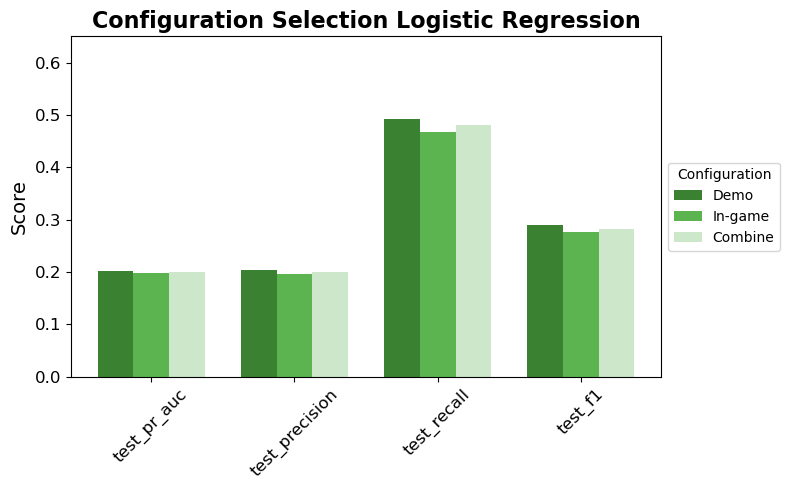

In [247]:
# Extract new labels and values
metrics = m1_config_scores.index #Each group on the x-axis
configs = m1_config_scores.columns # Each bar within a group
values = m1_config_scores.values # the height of the bar

# Bar setup
x = np.arange(len(metrics))
width = 0.25

# Color setting
colors_config = {
    'Demo': '#3b8132',       
    'In-game': '#5bb450',
    'Combine': '#cce7c9'}

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

for i, config in enumerate(configs):
    ax.bar(
        x + i * width,
        values[:, i],
        width,
        label=config,
        color=colors_config[config]
    )

# Axis titles
ax.set_ylabel('Score', fontsize=14)
ax.set_title(
    'Configuration Selection Logistic Regression',
    fontsize=16,
    fontweight='bold'
)

ax.set_xticks(x + width * (len(configs) - 1) / 2)
ax.set_xticklabels(metrics, rotation=45, fontsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0, 0.65)

ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title='Configuration'
)

plt.savefig('5.Configuration Selection_LR.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

##### Random Forest

In [249]:
# Combine into a dataframe for better plotting
m2_config_scores = pd.DataFrame({
    'Demo': mean_scores_m2_demo,
    'In-game': mean_scores_m2_game,
    'Combine': mean_scores_m2_combine})
m2_config_scores

,Demo,In-game,Combine
test_pr_auc,0.204746,0.197281,0.199415
test_precision,0.202959,0.198603,0.197860
test_recall,0.505518,0.295352,0.086896
test_f1,0.288887,0.237462,0.120713


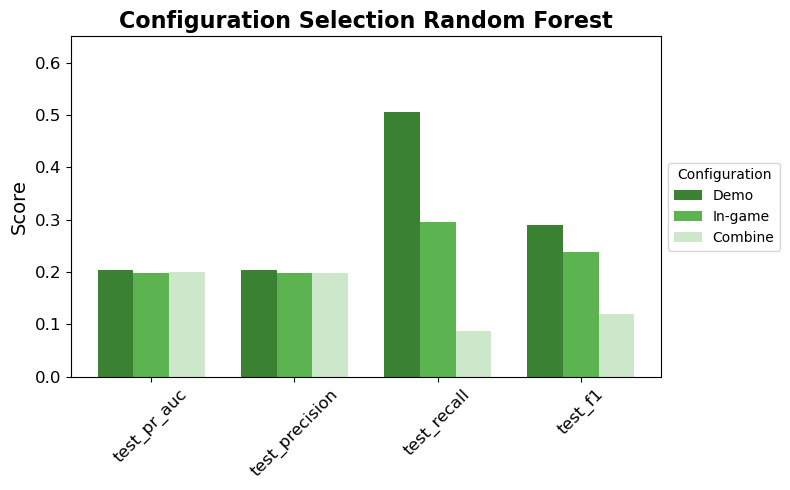

In [250]:
# Extract new labels and values
metrics = m2_config_scores.index
configs = m2_config_scores.columns
values = m2_config_scores.values

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

for i, config in enumerate(configs):
    ax.bar(
        x + i * width,
        values[:, i],
        width,
        label=config,
        color=colors_config[config]
    )

# Axis labels & title
ax.set_ylabel('Score', fontsize=14)
ax.set_title(
    'Configuration Selection Random Forest',
    fontsize=16,
    fontweight='bold'
)

ax.set_xticks(x + width * (len(configs) - 1) / 2)
ax.set_xticklabels(metrics, rotation=45, fontsize=12)

ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0, 0.65)

ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title='Configuration'
)
plt.savefig('6.Configuration Selection_Random Forest.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

##### XGBoost

In [252]:
# Combine into a dataframe for better plotting
m3_config_scores = pd.DataFrame({
    'Demo': mean_scores_m3_demo,
    'In-game': mean_scores_m3_game,
    'Combine': mean_scores_m3_combine})
m3_config_scores

,Demo,In-game,Combine
test_pr_auc,0.204997,0.194519,0.199049
test_precision,0.204534,0.198532,0.194516
test_recall,0.510493,0.430281,0.367480
test_f1,0.290732,0.271677,0.254362


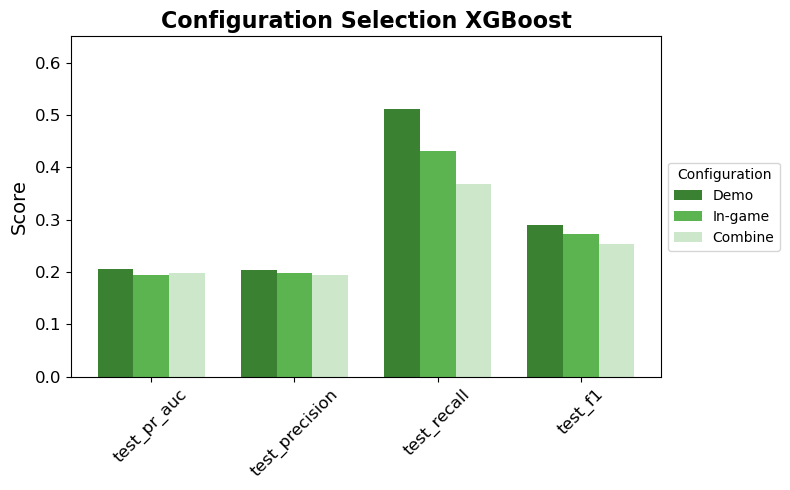

In [253]:
# Extract new labels and values
metrics = m3_config_scores.index
configs = m3_config_scores.columns
values = m3_config_scores.values

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

for i, config in enumerate(configs):
    ax.bar(
        x + i * width,
        values[:, i],
        width,
        label=config,
        color=colors_config[config]
    )

# Axis label & title
ax.set_ylabel('Score', fontsize=14)
ax.set_title(
    'Configuration Selection XGBoost',
    fontsize=16,
    fontweight='bold'
)

ax.set_xticks(x + width * (len(configs) - 1) / 2)
ax.set_xticklabels(metrics, rotation=45, fontsize=12)

ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0, 0.65)

ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title='Configuration'
)
plt.savefig('7. Configuration Selection_XGBoost.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

##### CatBoost

In [255]:
# Combine into a dataframe for better plotting
m4_config_scores = pd.DataFrame({
    'Demo': mean_scores_m4_demo,
    'In-game': mean_scores_m4_game,
    'Combine': mean_scores_m4_combine})
m4_config_scores

,Demo,In-game,Combine
test_pr_auc,0.204902,0.195181,0.200452
test_precision,0.204412,0.195904,0.197080
test_recall,0.542049,0.447070,0.399503
test_f1,0.296296,0.272408,0.263939


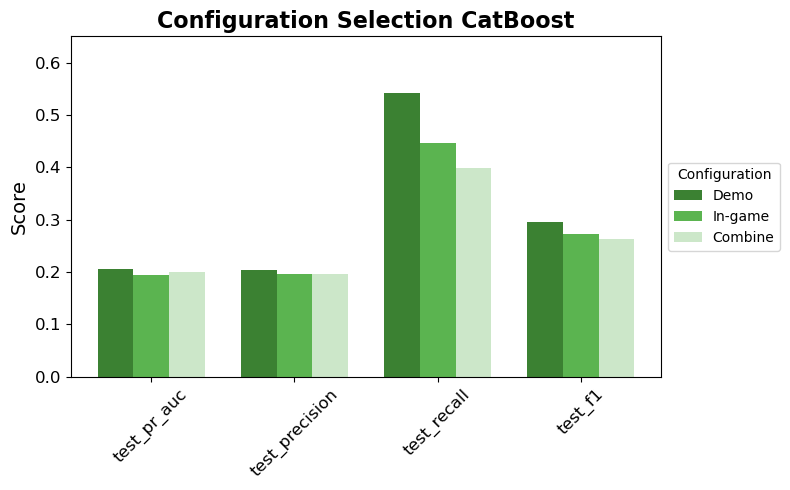

In [256]:
# Extract new labels and values
metrics = m4_config_scores.index
configs = m4_config_scores.columns
values = m4_config_scores.values

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

for i, config in enumerate(configs):
    ax.bar(
        x + i * width,
        values[:, i],
        width,
        label=config,
        color=colors_config[config]
    )

ax.set_ylabel('Score', fontsize=14)
ax.set_title(
    'Configuration Selection CatBoost',
    fontsize=16,
    fontweight='bold'
)

ax.set_xticks(x + width * (len(configs) - 1) / 2)
ax.set_xticklabels(metrics, rotation=45, fontsize=12)

ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0, 0.65)

ax.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=10,
    title='Configuration'
)

plt.savefig('8. Configuration Selection_CatBoost.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

#### Statistical Comparison

##### Logistic Regression

In [122]:
# Wilcoxon
print('Statistical Comparison of Logistic Regression on 3 configurations')
print('Demographic vs In-game:', wilcoxon(results_m1_demo['test_pr_auc'], results_m1_game['test_pr_auc']))
print('Demographic vs Combine:', wilcoxon(results_m1_demo['test_pr_auc'], results_m1_combine['test_pr_auc']))

Statistical Comparison of Logistic Regression on 3 configurations
Demographic vs In-game: WilcoxonResult(statistic=6.0, pvalue=0.21875)
Demographic vs Combine: WilcoxonResult(statistic=9.0, pvalue=0.46875)


##### Random Forest

In [124]:
# Wilcoxon
print('Statistical Comparison of Random Forest on 3 configurations')
print('Demographic vs In-game:', wilcoxon(results_m2_demo['test_pr_auc'], results_m2_game['test_pr_auc']))
print('Demographic vs Combine:', wilcoxon(results_m2_demo['test_pr_auc'], results_m2_combine['test_pr_auc']))

Statistical Comparison of Random Forest on 3 configurations
Demographic vs In-game: WilcoxonResult(statistic=0.0, pvalue=0.015625)
Demographic vs Combine: WilcoxonResult(statistic=4.0, pvalue=0.109375)


##### XGBoost

In [126]:
# Wilcoxon
print('Statistical Comparison of XGBoost on 3 configurations')
print('Demographic vs In-game:', wilcoxon(results_m3_demo['test_pr_auc'], results_m3_game['test_pr_auc']))
print('Demographic vs Combine:', wilcoxon(results_m3_demo['test_pr_auc'], results_m3_combine['test_pr_auc']))

Statistical Comparison of XGBoost on 3 configurations
Demographic vs In-game: WilcoxonResult(statistic=0.0, pvalue=0.015625)
Demographic vs Combine: WilcoxonResult(statistic=1.0, pvalue=0.03125)


##### CatBoost

In [128]:
# Wilcoxon
print('Statistical Comparison of CatBoost on 3 configurations')
print('Demographic vs In-game:', wilcoxon(results_m4_demo['test_pr_auc'], results_m4_game['test_pr_auc']))
print('Demographic vs Combine:', wilcoxon(results_m4_demo['test_pr_auc'], results_m4_combine['test_pr_auc']))

Statistical Comparison of CatBoost on 3 configurations
Demographic vs In-game: WilcoxonResult(statistic=0.0, pvalue=0.015625)
Demographic vs Combine: WilcoxonResult(statistic=4.0, pvalue=0.109375)


In [380]:
# Create Demographic test set
X_test_demo = X_test_selected[['Location', 'Gender','AgeGroup']]

# 6. Model Selection
- Check the result of the model from previous step (underfitting, overfitting)
- Tuning the model with the best configuration with random

## Training and Tuning

### Setting before tuning

In [176]:
metrics = ['mean_test_pr_auc', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']

### Logistic Regression

#### Trial experiments before tuning

In [180]:
# Add paramater to solve the underfitting and class-balance
model_1_tune = LogisticRegression(class_weight='balanced', C=0.01, penalty='l2', solver='liblinear',random_state=23)
cv_results_m1_tune = cross_validate(model_1_tune, X_train_demo, y_train, cv=cv, scoring=scoring, return_train_score=False)
result_m1_tune = pd.DataFrame(cv_results_m1_tune).filter(like='test_').mean()
print (result_m1_tune)

test_pr_auc       0.202413
test_precision    0.204606
test_recall       0.489974
test_f1           0.288596
dtype: float64


In [182]:
mean_scores_m1_demo

test_pr_auc       0.202505
test_precision    0.204661
test_recall       0.491373
test_f1           0.288877
dtype: float64

In [184]:
result_compare = pd.concat([mean_scores_m1_demo, result_m1_tune], axis=1).T
print(result_compare)

   test_pr_auc  test_precision  test_recall   test_f1
0     0.202505        0.204661     0.491373  0.288877
1     0.202413        0.204606     0.489974  0.288596


##### Regularization Strength (C)

In [164]:
# Larger C = Weaker regularization → more flexible model
model_1_tune = LogisticRegression(
    class_weight='balanced', 
    C=1, 
    penalty='l2', 
    solver='liblinear',
    max_iter=1000,
    random_state=23)
cv_results_m1_tune = cross_validate(model_1_tune, X_train_demo, y_train, cv=cv, scoring=scoring, return_train_score=False)
result_m1_tune = pd.DataFrame(cv_results_m1_tune).filter(like='test_').mean()
print (result_m1_tune)

test_pr_auc       0.202440
test_precision    0.204661
test_recall       0.491373
test_f1           0.288877
dtype: float64


In [165]:
# Larger C = Weaker regularization → more flexible model
model_1_tune = LogisticRegression(
    class_weight='balanced', 
    C=0.001, 
    penalty='l2', 
    solver='liblinear',
    max_iter=1000,
    random_state=23)
cv_results_m1_tune = cross_validate(model_1_tune, X_train_demo, y_train, cv=cv, scoring=scoring, return_train_score=False)
result_m1_tune = pd.DataFrame(cv_results_m1_tune).filter(like='test_').mean()
print (result_m1_tune)

test_pr_auc       0.203098
test_precision    0.204832
test_recall       0.454065
test_f1           0.281922
dtype: float64


##### Solver

In [167]:
# Solver adjust but the performance slightly changed
model_1_tune = LogisticRegression(
    class_weight='balanced', 
    C=0.01, 
    penalty='l2', 
    solver='saga',
    max_iter=1000,
    random_state=23)
cv_results_m1_tune = cross_validate(model_1_tune, X_train_demo, y_train, cv=cv, scoring=scoring, return_train_score=False)
result_m1_tune = pd.DataFrame(cv_results_m1_tune).filter(like='test_').mean()
print (result_m1_tune)

test_pr_auc       0.202445
test_precision    0.204636
test_recall       0.496658
test_f1           0.289756
dtype: float64


##### Maximum Iterations (max_iter)

In [169]:
# Increase iterations does not change the result
model_1_tune = LogisticRegression(
    class_weight='balanced', 
    C=0.01, 
    penalty='l2', 
    solver='saga',
    max_iter=5000,
    random_state=23)
cv_results_m1_tune = cross_validate(model_1_tune, X_train_demo, y_train, cv=cv, scoring=scoring, return_train_score=False)
result_m1_tune = pd.DataFrame(cv_results_m1_tune).filter(like='test_').mean()
print (result_m1_tune)

test_pr_auc       0.202445
test_precision    0.204636
test_recall       0.496658
test_f1           0.289756
dtype: float64


In [170]:
# Decrease iterations does not change the result
model_1_tune = LogisticRegression(
    class_weight='balanced', 
    C=0.01, 
    penalty='l2', 
    solver='saga',
    max_iter=100,
    random_state=23)
cv_results_m1_tune = cross_validate(model_1_tune, X_train_demo, y_train, cv=cv, scoring=scoring, return_train_score=False)
result_m1_tune = pd.DataFrame(cv_results_m1_tune).filter(like='test_').mean()
print (result_m1_tune)

test_pr_auc       0.202445
test_precision    0.204636
test_recall       0.496658
test_f1           0.289756
dtype: float64


#### Grid Search Tuning

In [186]:
param_grid_m1 = {
    'C': [1, 0.01, 0.001],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 1000, 2000], # since no negative affects, test all combination
    'class_weight': ['balanced']  # Keep handling imbalance
}

In [188]:
grid_search_m1 = GridSearchCV(
    LogisticRegression(random_state=23),
    param_grid_m1,
    scoring = scoring,
    refit='pr_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_m1.fit(X_train_demo, y_train)
print('Best Parameters:', grid_search_m1.best_params_)

Fitting 7 folds for each of 36 candidates, totalling 252 fits
Best Parameters: {'C': 0.001, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}


#### Result

In [189]:
result_tune_m1 = pd.DataFrame(grid_search_m1.cv_results_)

best_idx_m1 = grid_search_m1.best_index_
print (best_idx_m1)
best_result_m1 = result_tune_m1.iloc[best_idx_m1]
print (best_result_m1)

26
mean_fit_time                                                     0.044686
std_fit_time                                                      0.017272
mean_score_time                                                   0.040933
std_score_time                                                    0.007283
param_C                                                              0.001
param_class_weight                                                balanced
param_max_iter                                                         100
param_penalty                                                           l2
param_solver                                                     liblinear
params                   {'C': 0.001, 'class_weight': 'balanced', 'max_...
split0_test_pr_auc                                                0.208673
split1_test_pr_auc                                                0.196028
split2_test_pr_auc                                                0.204697
split3_test_pr_auc    

In [190]:
print('\nCross-Validation metrics for best paramaters:')
print('================================================')
for metric in metrics:
    print(f"{metric.replace('mean_test_', '')}: {best_result_m1[metric]:6f}")


Cross-Validation metrics for best paramaters:
pr_auc: 0.203098
precision: 0.204832
recall: 0.454065
f1: 0.281922


### Random Forest

#### Trial experiments before tuning

#####  n_estimators
- increase--> the result does not change much
- adding depth of tree to strengthen the configuration

In [194]:
model_tune_m2 = RandomForestClassifier(random_state=23,
    class_weight='balanced',
    n_estimators=500
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204598
test_precision    0.203263
test_recall       0.483911
test_f1           0.284970
dtype: float64


In [181]:
print(mean_scores_m2_demo)

test_pr_auc       0.204746
test_precision    0.202959
test_recall       0.505518
test_f1           0.288887
dtype: float64


In [182]:
model_tune_m2 = RandomForestClassifier(random_state=23,
    class_weight='balanced',
    n_estimators=200
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204659
test_precision    0.203785
test_recall       0.497124
test_f1           0.288121
dtype: float64


In [183]:
model_tune_m2 = RandomForestClassifier(random_state=23,
    class_weight='balanced',
    n_estimators=300
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204458
test_precision    0.203295
test_recall       0.505518
test_f1           0.289192
dtype: float64


In [184]:
model_tune_m2 = RandomForestClassifier(random_state=23,
    class_weight='balanced',
    n_estimators=800
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204730
test_precision    0.203392
test_recall       0.485466
test_f1           0.285293
dtype: float64


#####  Tree Depth
- combine with tree depth, the random combination does not improve the result much
- GridSearchCV to explore all possible combinations

In [186]:
# Combine with Tree Depth Increase
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=800,
    max_depth=30,
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204730
test_precision    0.203392
test_recall       0.485466
test_f1           0.285293
dtype: float64


In [187]:
# Combine with Tree Depth Increase
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=800,
    max_depth=50,
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204730
test_precision    0.203392
test_recall       0.485466
test_f1           0.285293
dtype: float64


In [188]:
# Combine with Tree Depth Increase
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=500,
    max_depth=50,
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204598
test_precision    0.203263
test_recall       0.483911
test_f1           0.284970
dtype: float64


#####  Allow more parameters for deeper trees, complex structure
- min_samples_split 
- min_samples_leaf
- ==> control splitting of the model
- the result does not change across evaluation metrics

In [190]:
# controlling split
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=800,
    max_depth=50,
    min_samples_split=2,
    min_samples_leaf=1
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204730
test_precision    0.203392
test_recall       0.485466
test_f1           0.285293
dtype: float64


In [191]:
# controlling split
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=800,
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=1
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204730
test_precision    0.203392
test_recall       0.485466
test_f1           0.285293
dtype: float64


In [192]:
# controlling split
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=800,
    max_depth=50,
    min_samples_split=5,
    min_samples_leaf=2
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204730
test_precision    0.203392
test_recall       0.485466
test_f1           0.285293
dtype: float64


#####  max_features
- the number of features of demographic is limited in 3 features
- so there are not many options to test on
- no adjustments detected

In [194]:
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=500,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=2
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204598
test_precision    0.203263
test_recall       0.483911
test_f1           0.284970
dtype: float64


In [195]:
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=500,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=3
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204598
test_precision    0.203263
test_recall       0.483911
test_f1           0.284970
dtype: float64


In [196]:
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=500,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt'
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204598
test_precision    0.203263
test_recall       0.483911
test_f1           0.284970
dtype: float64


#####  criterion
- same as max_features

In [198]:
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=500,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    criterion='gini'
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204598
test_precision    0.203263
test_recall       0.483911
test_f1           0.284970
dtype: float64


In [199]:
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=500,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    criterion='entropy'
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204598
test_precision    0.203263
test_recall       0.483911
test_f1           0.284970
dtype: float64


In [200]:
model_tune_m2 = RandomForestClassifier(
    random_state=23,
    class_weight='balanced',
    n_estimators=500,
    max_depth=30,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    criterion='log_loss'
)

cv_results_m2_tune = cross_validate(model_tune_m2, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m2_tune).filter(like='test_').mean())

test_pr_auc       0.204598
test_precision    0.203263
test_recall       0.483911
test_f1           0.284970
dtype: float64


#### GridSearch Tuning

In [195]:
param_grid_m2 = {
    'class_weight': ['balanced'],
    'max_features': [3],
    'criterion': ['log_loss'],
    'n_estimators': [300, 500, 800],
    'max_depth': [30, 50,80]
}

In [196]:
grid_search_m2 = GridSearchCV(
    RandomForestClassifier(random_state=23),
    param_grid_m2,
    scoring = scoring,
    refit='pr_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_m2.fit(X_train_demo, y_train)
print('Best Parameters:', grid_search_m2.best_params_)

Fitting 7 folds for each of 9 candidates, totalling 63 fits
Best Parameters: {'class_weight': 'balanced', 'criterion': 'log_loss', 'max_depth': 30, 'max_features': 3, 'n_estimators': 800}


#### Results

In [197]:
result_tune_m2 = pd.DataFrame(grid_search_m2.cv_results_)

best_idx_m2 = grid_search_m2.best_index_
best_result_m2 = result_tune_m2.iloc[best_idx_m2]
print('\nCross-Validation metrics for best paramaters:')
print('================================================')
for metric in metrics:
    print(f"{metric.replace('mean_test_', '')}: {best_result_m2[metric]:.6f}")


Cross-Validation metrics for best paramaters:
pr_auc: 0.204730
precision: 0.203392
recall: 0.485466
f1: 0.285293


### XGBoost

#### Trial experiments before tuning

In [208]:
print(mean_scores_m3_demo)

test_pr_auc       0.204997
test_precision    0.204534
test_recall       0.510493
test_f1           0.290732
dtype: float64


##### scale_pos_weight

In [198]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=5,
    random_state=23
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

## increase scale_pos_weight --> recall increase--> what predict positive is mostly positive.
## precision remain --> many negatives predicted as positives
## model react to higher weights on positive

test_pr_auc       0.205027
test_precision    0.200308
test_recall       0.987409
test_f1           0.333049
dtype: float64


##### n_estimator: number of trees
- more trees for finer learning
- adjust the number of trees only (300, 500, 800) does not adjust the result

In [212]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=800
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.204997
test_precision    0.204534
test_recall       0.510493
test_f1           0.290732
dtype: float64


##### n_estimator and max_depth
- increase 2 paramaters --> increase the PRAUC
- max depth: PRAUC stops increasing at 10
- n_estimator: PRAUC stops increasing at 500

In [214]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=500,
    max_depth=4
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.204965
test_precision    0.204342
test_recall       0.512980
test_f1           0.291075
dtype: float64


In [215]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=500,
    max_depth=11
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.205057
test_precision    0.204534
test_recall       0.510493
test_f1           0.290732
dtype: float64


In [216]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=600,
    max_depth=10
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.205057
test_precision    0.204534
test_recall       0.510493
test_f1           0.290732
dtype: float64


##### learning rate
- add learning rate: 0.03, 0.01, 0.005
-  --> smaller corrections on the later trees

In [218]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=300,
    max_depth=5,
    learning_rate = 0.03
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.204878
test_precision    0.204406
test_recall       0.509405
test_f1           0.290431
dtype: float64


In [219]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=300,
    max_depth=5,
    learning_rate = 0.01
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.205246
test_precision    0.202713
test_recall       0.526815
test_f1           0.291967
dtype: float64


In [220]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=500,
    max_depth=5,
    learning_rate = 0.005
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.205667
test_precision    0.202025
test_recall       0.530079
test_f1           0.291877
dtype: float64


##### Control sample of tree
- subsample: add randomness when tree selecting samples --> 1 get the highest score --> no need to set this paramater

In [222]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=300,
    max_depth=5,
    learning_rate = 0.001,
    subsample=0.8
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.205282
test_precision    0.203972
test_recall       0.529302
test_f1           0.293686
dtype: float64


In [223]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=300,
    max_depth=5,
    learning_rate = 0.001,
    subsample=1
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.206001
test_precision    0.202871
test_recall       0.512358
test_f1           0.289647
dtype: float64


##### Prevent waste in making not valuable splits
- gama: prevent recall overshoot, try to balance precision and recall 0.1, 1, 2. decrease at 3

In [225]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=300,  
    max_depth=5,
    learning_rate=0.001,
    gamma=2
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.207019
test_precision    0.204274
test_recall       0.488108
test_f1           0.285509
dtype: float64


##### Affect the weights of the leaf nodes
- reg_alpha: removes unnecessary features --> we just have 3 features --> unecessary
- reg_lambda: smooths the leaf values. Values tried 0.1, 0.5, 2

In [227]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.001,
    gamma=2,
    reg_lambda=0.5
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.207019
test_precision    0.203790
test_recall       0.483911
test_f1           0.284342
dtype: float64


In [228]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.001,
    gamma=2,
    reg_lambda=0.1
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.207019
test_precision    0.203856
test_recall       0.484844
test_f1           0.284691
dtype: float64


In [229]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.001,
    gamma=2,
    reg_lambda=1
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.207019
test_precision    0.204274
test_recall       0.488108
test_f1           0.285509
dtype: float64


In [230]:
model_tune_m3 = XGBClassifier(
    scale_pos_weight=ratio,
    random_state=23,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.001,
    gamma=2,
    reg_lambda=2
)
cv_results_m3_tune = cross_validate(model_tune_m3, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m3_tune).filter(like='test_').mean())

test_pr_auc       0.207018
test_precision    0.204274
test_recall       0.488108
test_f1           0.285509
dtype: float64


#### GridSearch Tuning

In [199]:
param_grid_m3 = {
    'scale_pos_weight': [ratio],
    'n_estimators': [800, 300, 500],
    'max_depth': [4,7,10],
    'learning_rate': [0.01, 0.005, 0.001],
    'reg_lambda': [2],
    'gamma': [1, 2]
}

In [200]:
grid_search_m3 = GridSearchCV(
    XGBClassifier(random_state=23),
    param_grid_m3,
    scoring = scoring,
    refit='pr_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_m3.fit(X_train_demo, y_train)

Fitting 7 folds for each of 54 candidates, totalling 378 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=23, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_typ...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=23, ...),
             n_jobs=-1,
             param_grid={'gamma': [1, 2], 'learning_rate': [0.01, 0.005, 0.001],
                         'max_depth': [4, 7, 10],
                         'n_estimators': [800, 300, 500], 'reg_lambda': [2],
                         'scale_pos_weight': [3.978548111301104]},
             refit='pr_auc',
             scoring={'f1': 'f1', 'pr_auc': 'average_precision',
                      'precision': 'precision', 'recall': 'recall'},
             verbose=1)

In [203]:
print('Best Parameters:', grid_search_m3.best_params_)

Best Parameters: {'gamma': 2, 'learning_rate': 0.001, 'max_depth': 7, 'n_estimators': 300, 'reg_lambda': 2, 'scale_pos_weight': 3.978548111301104}


#### Results

In [205]:
result_tune_m3 = pd.DataFrame(grid_search_m3.cv_results_)

best_idx_m3 = grid_search_m3.best_index_
best_result_m3 = result_tune_m3.iloc[best_idx_m3]
print('\nCross-Validation metrics for best paramaters:')
print('================================================')
for metric in metrics:
    print(f"{metric.replace('mean_test_', '')}: {best_result_m3[metric]:.6f}")


Cross-Validation metrics for best paramaters:
pr_auc: 0.206539
precision: 0.203652
recall: 0.474895
f1: 0.283364


### CatBoost

#### Trial experiments before tuning

In [239]:
print(mean_scores_m4_demo)

test_pr_auc       0.204902
test_precision    0.204412
test_recall       0.542049
test_f1           0.296296
dtype: float64


In [206]:
class_weights = [1, ratio]

##### Learning rate
- adjust to the range of 0.001, 0.005, 0.002.
- PR-AUC improves when learning_rate get smaller

In [242]:
model_tune_m4 = CatBoostClassifier(
    verbose=0, 
    class_weights=class_weights, 
    random_state=23,
    learning_rate=0.001
)
cv_results_m4_tune = cross_validate(model_tune_m4, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m4_tune).filter(like='test_').mean())

test_pr_auc       0.206176
test_precision    0.202664
test_recall       0.445360
test_f1           0.277428
dtype: float64


In [243]:
model_tune_m4 = CatBoostClassifier(
    verbose=0, 
    class_weights=class_weights, 
    random_state=23,
    learning_rate=0.01
)
cv_results_m4_tune = cross_validate(model_tune_m4, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m4_tune).filter(like='test_').mean())

test_pr_auc       0.205386
test_precision    0.203454
test_recall       0.503187
test_f1           0.288493
dtype: float64


##### iterations
- number of trees 1000, 2000, 3000
- --> slightly increase PRAUC

In [245]:
model_tune_m4 = CatBoostClassifier(
    verbose=0, 
    class_weights=class_weights, 
    random_state=23,
    learning_rate=0.001, 
    iterations=1000
)
cv_results_m4_tune = cross_validate(model_tune_m4, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m4_tune).filter(like='test_').mean())

test_pr_auc       0.206176
test_precision    0.202664
test_recall       0.445360
test_f1           0.277428
dtype: float64


In [246]:
model_tune_m4 = CatBoostClassifier(
    verbose=0, 
    class_weights=class_weights, 
    random_state=23,
    learning_rate=0.001, 
    iterations=2000
)
cv_results_m4_tune = cross_validate(model_tune_m4, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m4_tune).filter(like='test_').mean())

test_pr_auc       0.206101
test_precision    0.203110
test_recall       0.462926
test_f1           0.280895
dtype: float64


##### Depth
- 5 and 4 increase performance. 

In [248]:
model_tune_m4 = CatBoostClassifier(
    verbose=0, 
    class_weights=class_weights, 
    random_state=23,
    learning_rate=0.001,
    iterations=1000,
    depth = 5
)
cv_results_m4_tune = cross_validate(model_tune_m4, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m4_tune).filter(like='test_').mean())

test_pr_auc       0.206193
test_precision    0.203154
test_recall       0.438209
test_f1           0.276743
dtype: float64


In [249]:
model_tune_m4 = CatBoostClassifier(
    verbose=0, 
    class_weights=class_weights, 
    random_state=23,
    learning_rate=0.001,
    iterations=1000,
    depth = 4
)
cv_results_m4_tune = cross_validate(model_tune_m4, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m4_tune).filter(like='test_').mean())

test_pr_auc       0.206325
test_precision    0.205948
test_recall       0.432458
test_f1           0.278144
dtype: float64


##### l2_leaf_reg
- set penalty
- default is 3, 2 (slightly decrease). 4, 5, 6 is okay

In [251]:
model_tune_m4 = CatBoostClassifier(
    verbose=0, 
    class_weights=class_weights, 
    random_state=23,
    learning_rate=0.001,
    depth = 4,
    iterations=1000,
    l2_leaf_reg = 4
)
cv_results_m4_tune = cross_validate(model_tune_m4, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m4_tune).filter(like='test_').mean())

test_pr_auc       0.206330
test_precision    0.205106
test_recall       0.439142
test_f1           0.278480
dtype: float64


In [252]:
model_tune_m4 = CatBoostClassifier(
    verbose=0, 
    class_weights=class_weights, 
    random_state=23,
    learning_rate=0.001,
    depth = 4,
    iterations=1000,
    l2_leaf_reg = 5
)
cv_results_m4_tune = cross_validate(model_tune_m4, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m4_tune).filter(like='test_').mean())

test_pr_auc       0.206263
test_precision    0.204496
test_recall       0.447536
test_f1           0.280229
dtype: float64


##### subsample
- % of samples used to grow each tree -> add randomness
- adjust from 0.9, 0.8

In [254]:
model_tune_m4 = CatBoostClassifier(
    verbose=0, 
    class_weights=class_weights, 
    random_state=23,
    learning_rate=0.002, 
    depth = 4,
    l2_leaf_reg = 5,
    iterations=1000,
    subsample=0.9
)
cv_results_m4_tune = cross_validate(model_tune_m4, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m4_tune).filter(like='test_').mean())

test_pr_auc       0.206255
test_precision    0.204745
test_recall       0.438831
test_f1           0.278234
dtype: float64


In [255]:
model_tune_m4 = CatBoostClassifier(
    verbose=0, 
    class_weights=class_weights, 
    random_state=23,
    learning_rate=0.002, 
    depth = 4,
    l2_leaf_reg = 5,
    iterations=1000,
    subsample=0.8
)
cv_results_m4_tune = cross_validate(model_tune_m4, X_train_demo, y_train, cv=cv, scoring=scoring)
print(pd.DataFrame(cv_results_m4_tune).filter(like='test_').mean())

test_pr_auc       0.206107
test_precision    0.203922
test_recall       0.432458
test_f1           0.275593
dtype: float64


#### GridSearch Tuning

In [207]:
param_grid_m4 = {
    'learning_rate': [0.001, 0.002, 0.005],
    'iterations': [1000],
    'depth': [4, 5],
    'l2_leaf_reg': [5, 6],
    'subsample' : [0.8, 0.9]
}

In [208]:
grid_search_m4 = GridSearchCV(
    CatBoostClassifier(random_state=23, verbose=0, class_weights=class_weights),
    param_grid_m4,
    scoring = scoring,
    refit='pr_auc',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search_m4.fit(X_train_demo, y_train)

Fitting 7 folds for each of 24 candidates, totalling 168 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=23, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x000001E417748EE0>,
             n_jobs=-1,
             param_grid={'depth': [4, 5], 'iterations': [1000],
                         'l2_leaf_reg': [5, 6],
                         'learning_rate': [0.001, 0.002, 0.005],
                         'subsample': [0.8, 0.9]},
             refit='pr_auc',
             scoring={'f1': 'f1', 'pr_auc': 'average_precision',
                      'precision': 'precision', 'recall': 'recall'},
             verbose=1)

#### Results

In [209]:
print('Best Parameters:', grid_search_m4.best_params_)

Best Parameters: {'depth': 5, 'iterations': 1000, 'l2_leaf_reg': 6, 'learning_rate': 0.001, 'subsample': 0.9}


In [210]:
result_tune_m4 = pd.DataFrame(grid_search_m4.cv_results_)

best_idx_m4 = grid_search_m4.best_index_
best_result_m4 = result_tune_m4.iloc[best_idx_m4]
print('\nCross-Validation metrics for best paramaters:')
print("================================================")
for metric in metrics:
    print(f"{metric.replace('mean_test_', '')}: {best_result_m4[metric]:.6f}")


Cross-Validation metrics for best paramaters:
pr_auc: 0.206474
precision: 0.203675
recall: 0.436188
f1: 0.276046


## Model comparison

### Bar plot to compare

In [211]:
# Create the comparison table
final_compare = {
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'CatBoost'],
    'PR_AUC': [
        best_result_m1['mean_test_pr_auc'],
        best_result_m2['mean_test_pr_auc'],
        best_result_m3['mean_test_pr_auc'],
        best_result_m4['mean_test_pr_auc']
    ],
    'Precision': [
        best_result_m1['mean_test_precision'],
        best_result_m2['mean_test_precision'],
        best_result_m3['mean_test_precision'],
        best_result_m4['mean_test_precision']
    ],
    'Recall': [
        best_result_m1['mean_test_recall'],
        best_result_m2['mean_test_recall'],
        best_result_m3['mean_test_recall'],
        best_result_m4['mean_test_recall']
    ],
    'F1': [
        best_result_m1['mean_test_f1'],
        best_result_m2['mean_test_f1'],
        best_result_m3['mean_test_f1'],
        best_result_m4['mean_test_f1']
    ]
}

final_compare = pd.DataFrame(final_compare)
print(final_compare)

                 Model    PR_AUC  Precision    Recall        F1
0  Logistic Regression  0.203098   0.204832  0.454065  0.281922
1        Random Forest  0.204730   0.203392  0.485466  0.285293
2              XGBoost  0.206539   0.203652  0.474895  0.283364
3             CatBoost  0.206474   0.203675  0.436188  0.276046


In [212]:
print (metrics)

['mean_test_pr_auc', 'mean_test_precision', 'mean_test_recall', 'mean_test_f1']


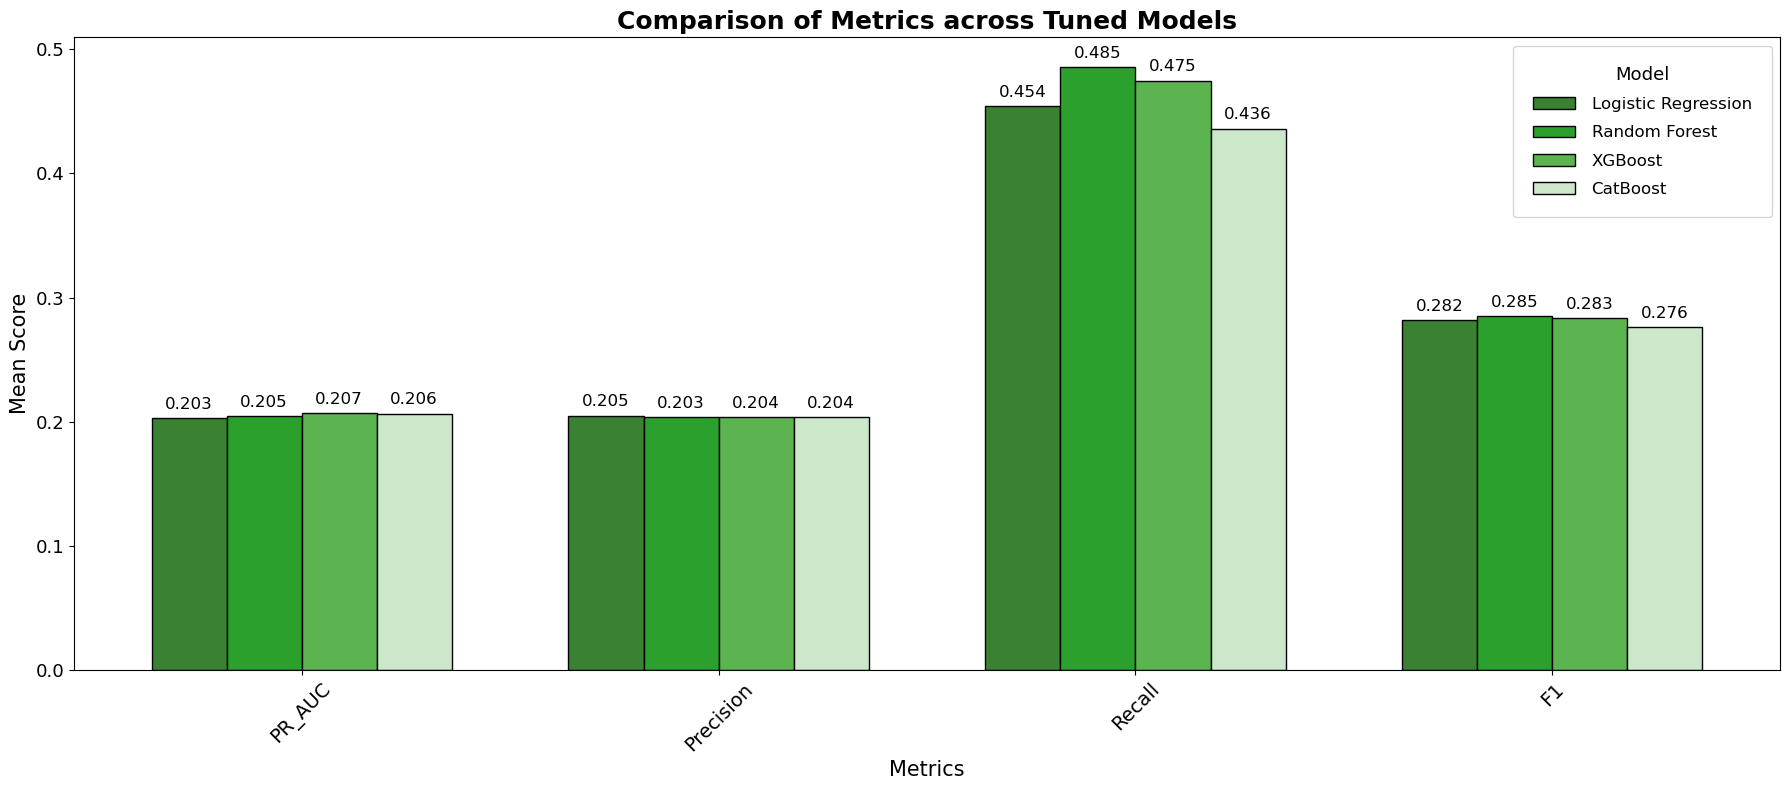

In [285]:
final_metrics = ['PR_AUC', 'Precision', 'Recall', 'F1']
x = np.arange(len(final_metrics))
width = 0.18

fig, ax = plt.subplots(figsize=(18,8))


model_colors = ['#3b8132', '#2ca02c', '#5bb450', '#cce7c9']

for i, (model, color) in enumerate(zip(final_compare['Model'], model_colors)):
    bars = ax.bar(
        x + i * width,
        final_compare.loc[i, final_metrics],
        width,
        label=model,
        color=color,
        edgecolor='black'
    )

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.005,
            f"{height:.3f}",
            ha='center',
            va='bottom',
            fontsize=12,
            color='black'
        )

# Axis titles
ax.set_title(
    'Comparison of Metrics across Tuned Models',
    fontsize=18,
    fontweight='bold'
)
ax.set_ylabel('Mean Score', fontsize=15)
ax.set_xlabel('Metrics', fontsize=15)

# Tick labels 
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(final_metrics, rotation=45, fontsize=14)
ax.tick_params(axis='y', labelsize=13)

# Legend
ax.legend(
    title='Model',
    title_fontsize=13,
    fontsize=12,          
    loc='upper right',
    frameon=True,
    borderpad=1.2,        
    labelspacing=0.8,     
    handlelength=2.5,     
    handletextpad=1.0     
)


plt.savefig('17. Final Comparison of Metrics across Models.png', dpi=500, bbox_inches='tight')
plt.tight_layout()
plt.show()

### Statistical Comparison
XGBoost edges out numerically and is slightly more stable across metrics.

#### PR-AUC - Statistical Comparison

##### Get the PR-AUC score of each fold of each model

In [287]:
## XGBoost 
result_tune_m3 = pd.DataFrame(grid_search_m3.cv_results_)
best_idx_m3 = grid_search_m3.best_index_
scores_auc_m3 = result_tune_m3.loc[best_idx_m3, 
    [c for c in result_tune_m3.columns if "split" in c and "test_pr_auc" in c]
].values
scores_auc_m3

array([0.2061631150852141, 0.2051790972403929, 0.21044379640905986,
       0.20984587336036065, 0.20090399144450533, 0.2086348728013161,
       0.20460347809852525], dtype=object)

In [289]:
## Logistic Regression
result_tune_m1 = pd.DataFrame(grid_search_m1.cv_results_)
best_idx_m1 = grid_search_m1.best_index_
scores_auc_m1 = result_tune_m1.loc[best_idx_m1, 
    [c for c in result_tune_m1.columns if "split" in c and "test_pr_auc" in c]
].values

In [291]:
## Random Forest
result_tune_m2 = pd.DataFrame(grid_search_m2.cv_results_)
best_idx_m2 = grid_search_m2.best_index_
scores_auc_m2 = result_tune_m2.loc[best_idx_m2, 
    [c for c in result_tune_m2.columns if "split" in c and "test_pr_auc" in c]
].values

In [293]:
## CatBoost
result_tune_m4 = pd.DataFrame(grid_search_m4.cv_results_)
best_idx_m4 = grid_search_m4.best_index_
scores_auc_m4 = result_tune_m4.loc[best_idx_m4, 
    [c for c in result_tune_m4.columns if "split" in c and "test_pr_auc" in c]
].values

##### Implementing Paired-wise test

In [296]:
# XGBoost with other 3 models
print('Statistical Comparison of XGBoost with other 3 models')
print('XGBoost vs Logistic Regression:', wilcoxon(scores_auc_m3, scores_auc_m1),'\n')
print('XGBoost vs Random Forest:', wilcoxon(scores_auc_m3, scores_auc_m2),'\n')
print('XGBoost vs CatBoost:', wilcoxon(scores_auc_m3, scores_auc_m4))

Statistical Comparison of XGBoost with other 3 models
XGBoost vs Logistic Regression: WilcoxonResult(statistic=7.0, pvalue=0.296875) 

XGBoost vs Random Forest: WilcoxonResult(statistic=2.0, pvalue=0.046875) 

XGBoost vs CatBoost: WilcoxonResult(statistic=12.0, pvalue=0.8125)


#### Secondary metrics - Statistical Comparison with XGBoost and CatBoost

##### Precision

In [300]:
## XGBoost
scores_precision_m3 = result_tune_m3.loc[best_idx_m3, 
    [c for c in result_tune_m3.columns if 'split' in c and 'test_precision' in c]
].values

## CatBoost
scores_precision_m4 = result_tune_m4.loc[best_idx_m4, 
    [c for c in result_tune_m4.columns if 'split' in c and 'test_precision' in c]
].values

In [302]:
# Wilcoxon
print('Precision - Statistical Comparison of XGBoost with CatBoost \n')
print('XGBoost vs CatBoost:', wilcoxon(scores_precision_m3, scores_precision_m4))

Precision - Statistical Comparison of XGBoost with CatBoost 

XGBoost vs CatBoost: WilcoxonResult(statistic=13.0, pvalue=0.9375)


##### Recall

In [304]:
## XGBoost
scores_recall_m3 = result_tune_m3.loc[best_idx_m3, 
    [c for c in result_tune_m3.columns if 'split' in c and 'test_recall' in c]
].values

## CatBoost
scores_recall_m4 = result_tune_m4.loc[best_idx_m4, 
    [c for c in result_tune_m4.columns if 'split' in c and 'test_recall' in c]
].values

In [306]:
# Wilcoxon
print('Recall - Statistical Comparison of XGBoost with CatBoost \n')
print('XGBoost vs CatBoost:', wilcoxon(scores_recall_m3, scores_recall_m4))

Recall - Statistical Comparison of XGBoost with CatBoost 

XGBoost vs CatBoost: WilcoxonResult(statistic=3.0, pvalue=0.078125)


##### F1

In [309]:
## XGBoost
scores_f1_m3 = result_tune_m3.loc[best_idx_m3, 
    [c for c in result_tune_m3.columns if 'split' in c and 'test_f1' in c]
].values

## CatBoost
scores_f1_m4 = result_tune_m4.loc[best_idx_m4, 
    [c for c in result_tune_m4.columns if 'split' in c and 'test_f1' in c]
].values

In [311]:
# Wilcoxon
print('F1 - Statistical Comparison of XGBoost with CatBoost \n')
print('XGBoost vs CatBoost:', wilcoxon(scores_f1_m3, scores_f1_m4))

F1 - Statistical Comparison of XGBoost with CatBoost 

XGBoost vs CatBoost: WilcoxonResult(statistic=6.0, pvalue=0.21875)


### PR AUC Curve and Confusion Matrix

#### Logistic Regression

In [315]:
# Best model from CV
best_m1 = grid_search_m1.best_estimator_

# Predictions and probabilities
y_pred_prob_cv_m1 = cross_val_predict(best_m1, X_train_demo, y_train, 
                                   cv=cv, method='predict_proba')[:, 1]
y_pred_cv_m1 = (y_pred_prob_cv_m1 >= 0.5).round().astype(int)

In [317]:
y_pred_prob_cv_m1

array([0.50926808, 0.49218467, 0.49326465, ..., 0.50168401, 0.49218467,
       0.50256695])

In [319]:
y_pred_cv_m1

array([1, 0, 0, ..., 1, 0, 1])

In [321]:
# Compute PRAUC
precision_cv_m1, recall_cv_m1, _ = precision_recall_curve(y_train, y_pred_prob_cv_m1)
pr_auc_cv_m1 = average_precision_score(y_train, y_pred_prob_cv_m1)

In [323]:
cm_cv_m1 = confusion_matrix(y_train, y_pred_cv_m1)

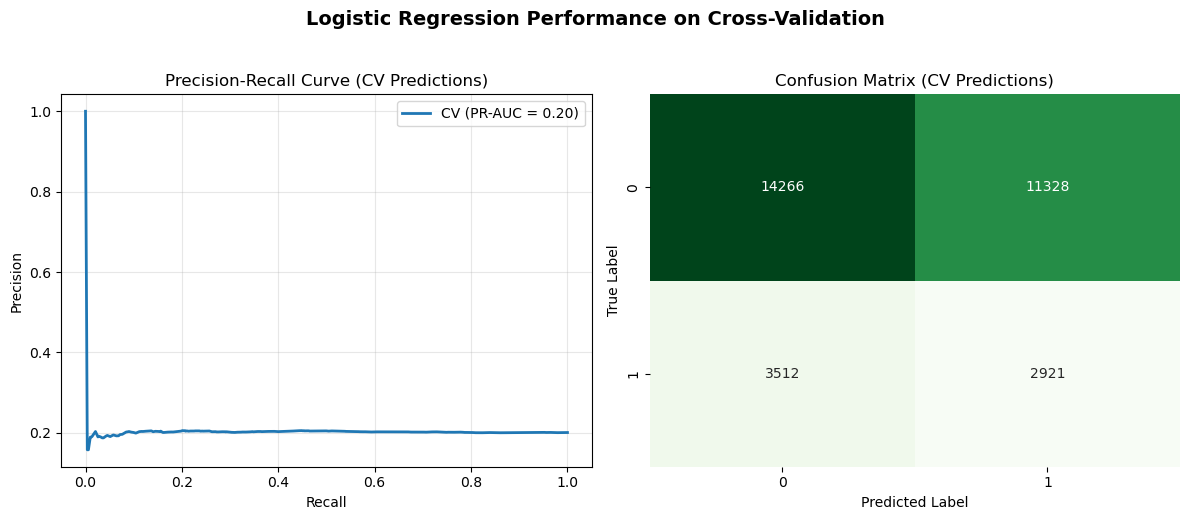

In [325]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PR curve
axes[0].plot(recall_cv_m1, precision_cv_m1, linewidth=2, label=f'CV (PR-AUC = {pr_auc_cv_m1:.2f})')
axes[0].set_title('Precision-Recall Curve (CV Predictions)')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix
sns.heatmap(cm_cv_m1, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('Confusion Matrix (CV Predictions)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

fig.suptitle('Logistic Regression Performance on Cross-Validation',
             fontsize=14, fontweight='bold', y=1.03)

plt.tight_layout()
plt.savefig('18. Logistic_CM_and_PRAUC_CV.png', dpi=300, bbox_inches='tight')
plt.show()

#### Random Forest

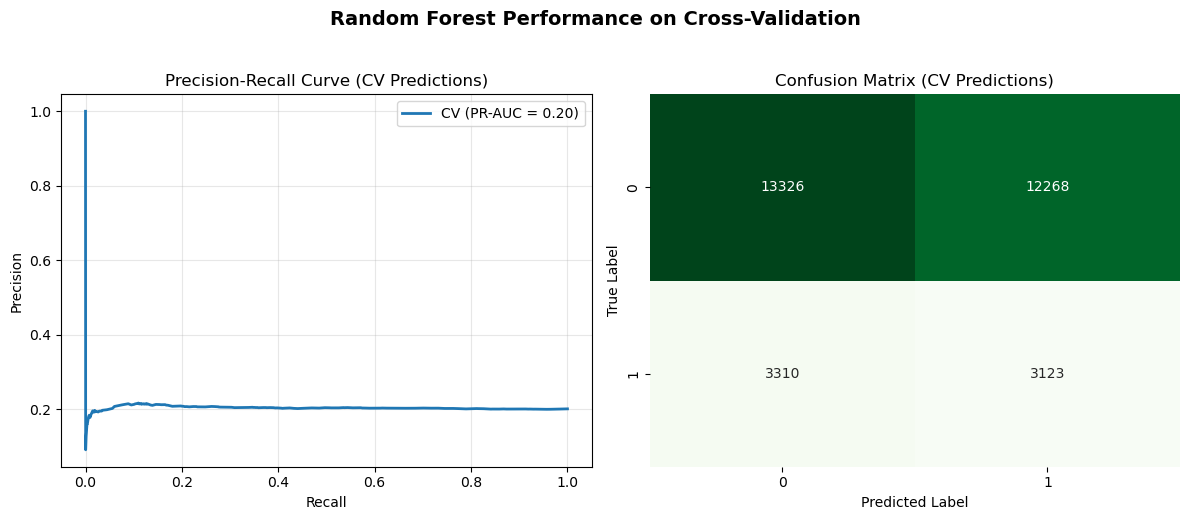

In [327]:
# Best model from CV
best_m2 = grid_search_m2.best_estimator_

# Predictions and probabilities
y_pred_prob_cv_m2 = cross_val_predict(best_m2, X_train_demo, y_train, 
                                   cv=cv, method='predict_proba')[:, 1]
y_pred_cv_m2 = (y_pred_prob_cv_m2 >= 0.5).round().astype(int)

# Compute PRAUC
precision_cv_m2, recall_cv_m2, _ = precision_recall_curve(y_train, y_pred_prob_cv_m2)
pr_auc_cv_m2 = average_precision_score(y_train, y_pred_prob_cv_m2)

cm_cv_m2 = confusion_matrix(y_train, y_pred_cv_m2)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PR curve
axes[0].plot(recall_cv_m2, precision_cv_m2, linewidth=2, label=f'CV (PR-AUC = {pr_auc_cv_m2:.2f})')
axes[0].set_title('Precision-Recall Curve (CV Predictions)')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix
sns.heatmap(cm_cv_m2, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('Confusion Matrix (CV Predictions)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

fig.suptitle('Random Forest Performance on Cross-Validation',
             fontsize=14, fontweight='bold', y=1.03)

plt.tight_layout()
plt.savefig('19. RF_CM_and_PRAUC_CV.png', dpi=300, bbox_inches='tight')
plt.show()

#### XGBoost

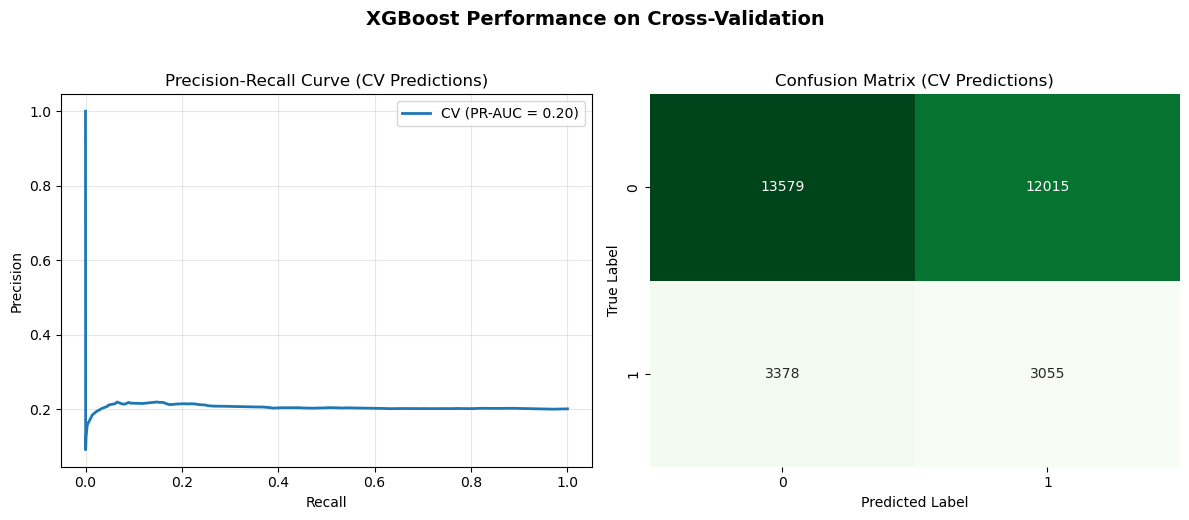

In [329]:
# Best model from CV
best_m3 = grid_search_m3.best_estimator_

# Predictions and probabilities
y_pred_prob_cv_m3 = cross_val_predict(best_m3, X_train_demo, y_train, 
                                   cv=cv, method='predict_proba')[:, 1]
y_pred_cv_m3 = (y_pred_prob_cv_m3 >= 0.5).round().astype(int)

# Compute PRAUC
precision_cv_m3, recall_cv_m3, _ = precision_recall_curve(y_train, y_pred_prob_cv_m3)
pr_auc_cv_m3 = average_precision_score(y_train, y_pred_prob_cv_m3)

cm_cv_m3 = confusion_matrix(y_train, y_pred_cv_m3)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PR curve
axes[0].plot(recall_cv_m3, precision_cv_m3, linewidth=2, label=f'CV (PR-AUC = {pr_auc_cv_m3:.2f})')
axes[0].set_title('Precision-Recall Curve (CV Predictions)')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix
sns.heatmap(cm_cv_m3, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('Confusion Matrix (CV Predictions)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

fig.suptitle('XGBoost Performance on Cross-Validation',
             fontsize=14, fontweight='bold', y=1.03)

plt.tight_layout()
plt.savefig('20. XGBoost_CM_and_PRAUC_CV.png', dpi=300, bbox_inches='tight')
plt.show()

#### CatBoost

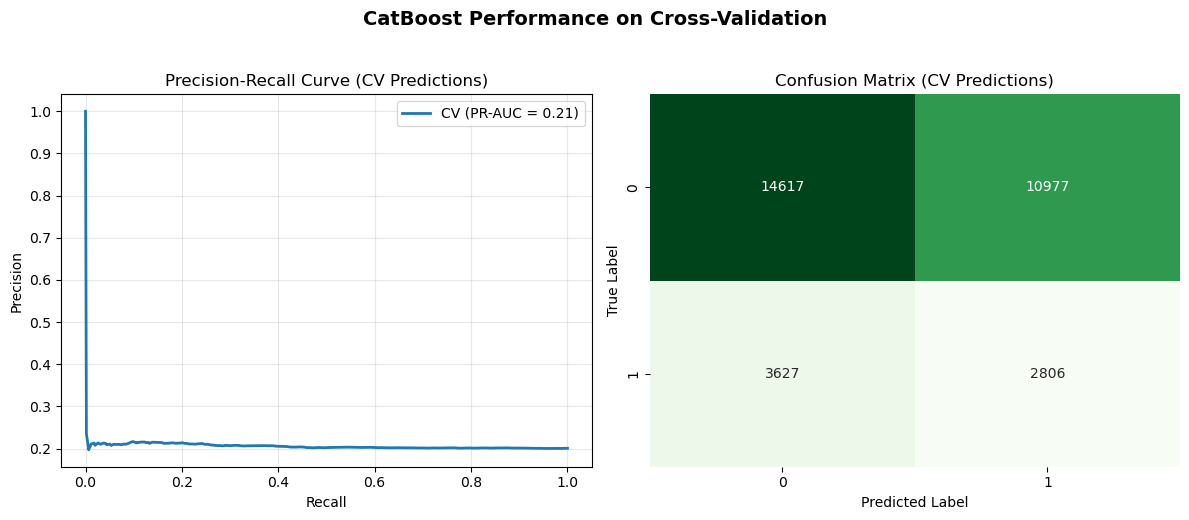

In [331]:
# Best model from CV
best_m4 = grid_search_m4.best_estimator_

# Predictions and probabilities
y_pred_prob_cv_m4 = cross_val_predict(best_m4, X_train_demo, y_train, 
                                   cv=cv, method='predict_proba')[:, 1]
y_pred_cv_m4 = (y_pred_prob_cv_m4 >= 0.5).round().astype(int)

# Compute PRAUC
precision_cv_m4, recall_cv_m4, _ = precision_recall_curve(y_train, y_pred_prob_cv_m4)
pr_auc_cv_m4 = average_precision_score(y_train, y_pred_prob_cv_m4)

cm_cv_m4 = confusion_matrix(y_train, y_pred_cv_m4)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PR curve
axes[0].plot(recall_cv_m4, precision_cv_m4, linewidth=2, label=f'CV (PR-AUC = {pr_auc_cv_m4:.2f})')
axes[0].set_title('Precision-Recall Curve (CV Predictions)')
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion matrix
sns.heatmap(cm_cv_m4, annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1])
axes[1].set_title('Confusion Matrix (CV Predictions)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

fig.suptitle('CatBoost Performance on Cross-Validation',
             fontsize=14, fontweight='bold', y=1.03)

plt.tight_layout()
plt.savefig('21. CatBoost_CM_and_PRAUC_CV.png', dpi=300, bbox_inches='tight')
plt.show()

#### Combine in one image

##### PR-Curve

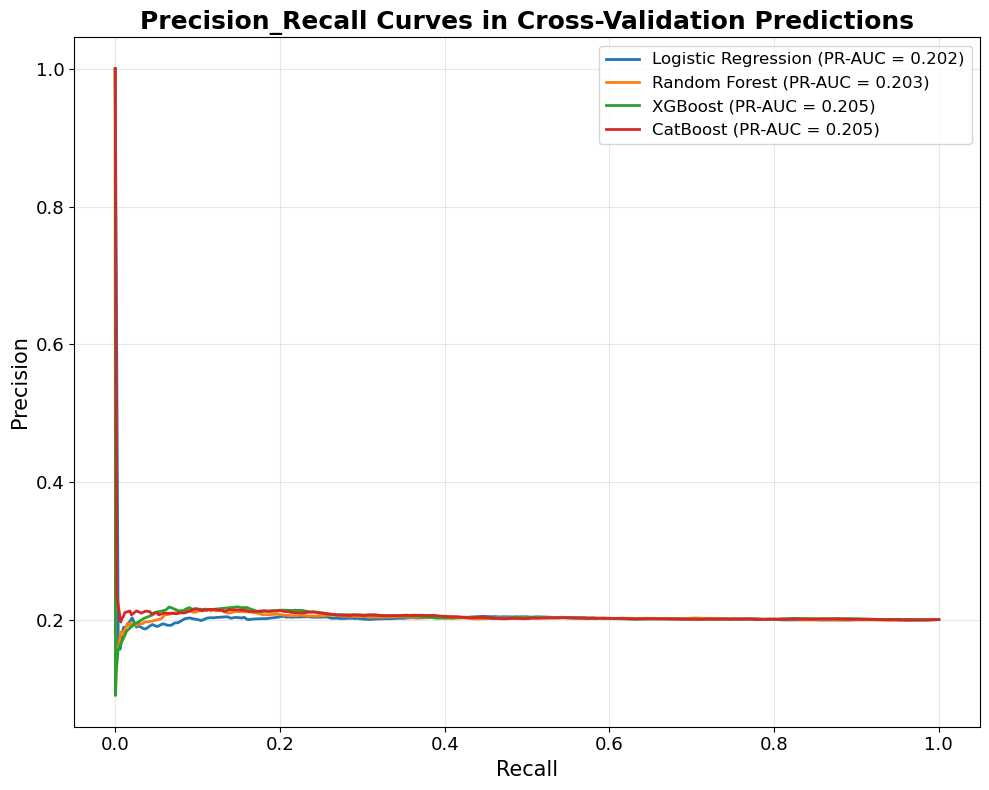

In [337]:
plt.figure(figsize=(10, 8))

# Logistic Regression
plt.plot(recall_cv_m1, precision_cv_m1, linewidth=2, label=f"Logistic Regression (PR-AUC = {pr_auc_cv_m1:.3f})")

# Random Forest
plt.plot(recall_cv_m2, precision_cv_m2, linewidth=2, label=f"Random Forest (PR-AUC = {pr_auc_cv_m2:.3f})")

# XGBoost
plt.plot(recall_cv_m3, precision_cv_m3, linewidth=2, label=f"XGBoost (PR-AUC = {pr_auc_cv_m3:.3f})")

# CatBoost
plt.plot(recall_cv_m4, precision_cv_m4, linewidth=2, label=f"CatBoost (PR-AUC = {pr_auc_cv_m4:.3f})")


plt.title(
    'Precision_Recall Curves in Cross-Validation Predictions',
    fontsize=18,
    fontweight='bold'
)

plt.xlabel('Recall', fontsize=15)
plt.ylabel('Precision', fontsize=15)

# Tick labels
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('22_precision_recall_curves.png', dpi=500, bbox_inches='tight')
plt.show()

##### Confusion Matrix

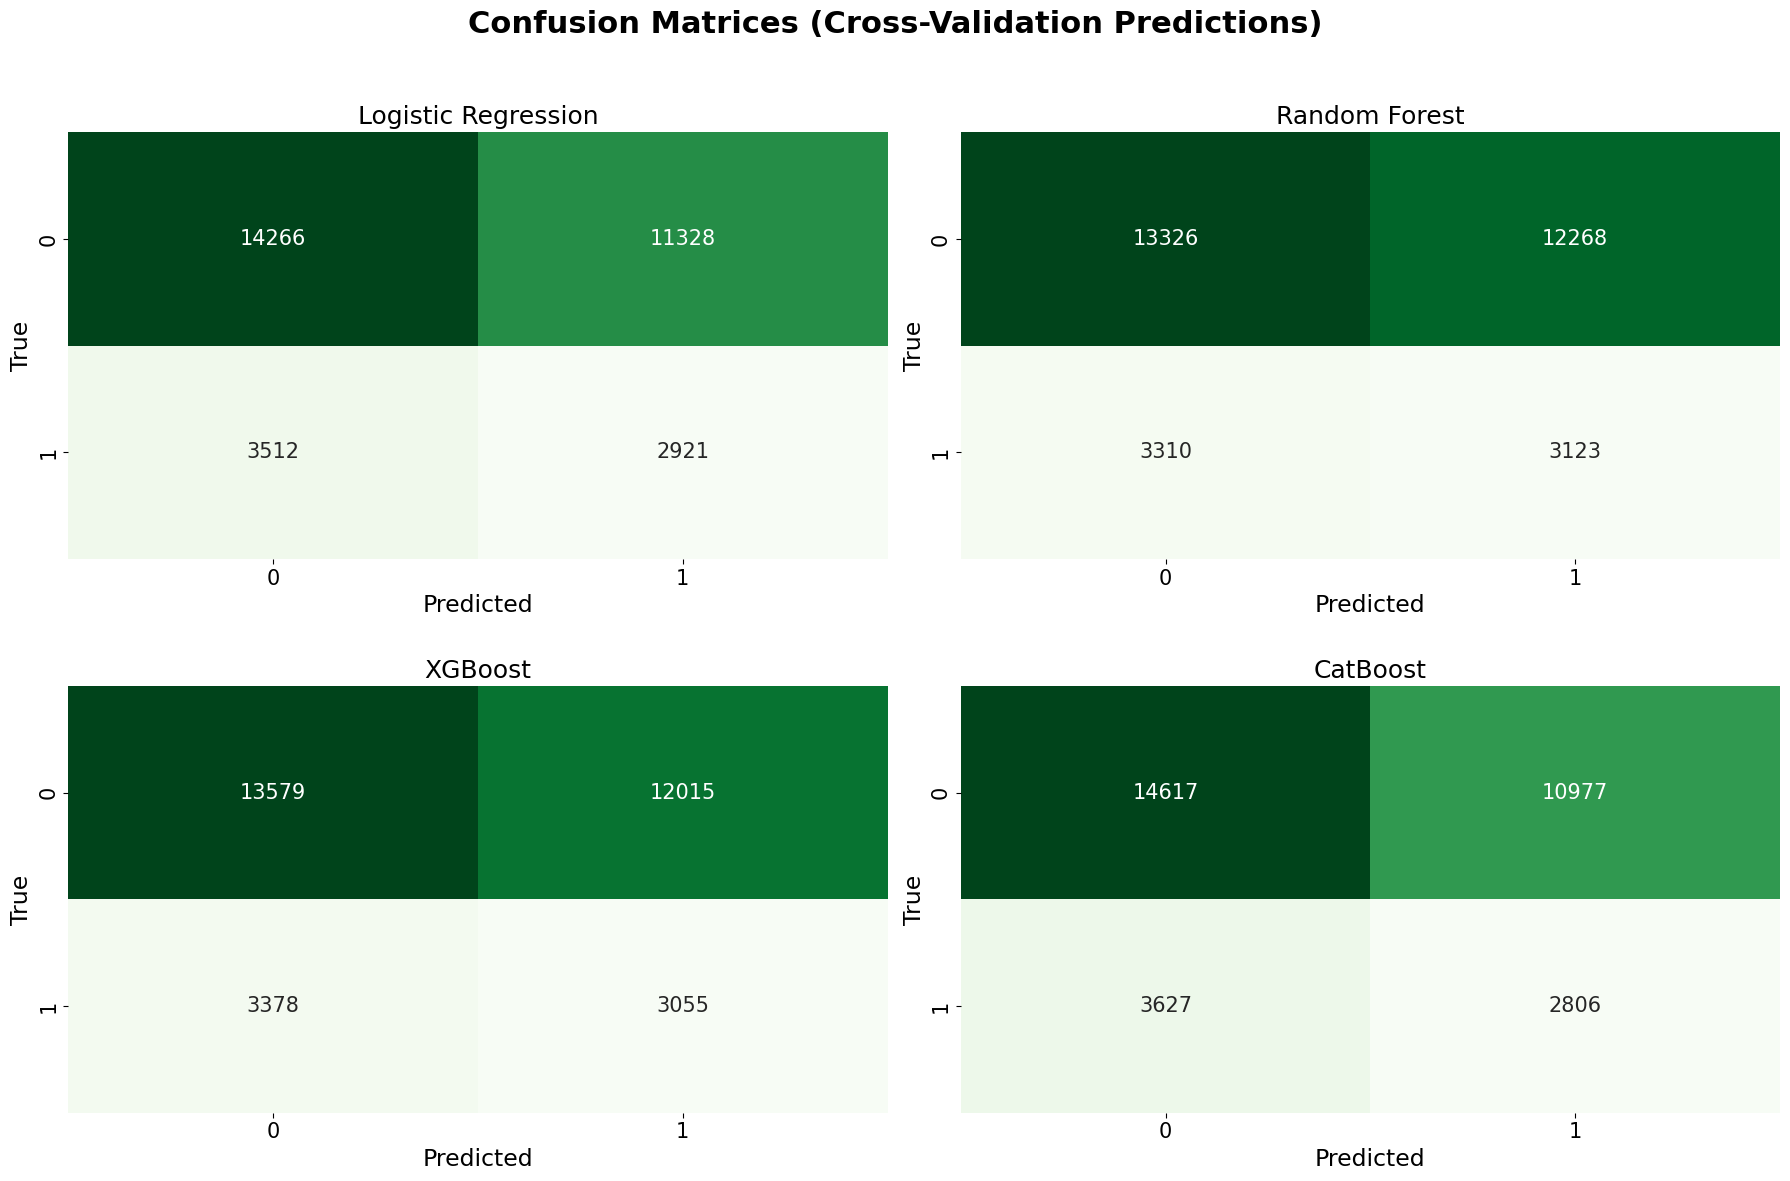

In [371]:
fig, axes = plt.subplots(2, 2, figsize=(18,12))

# Common font sizes
TITLE_FS = 18
AXIS_LABEL_FS = 17
TICK_LABEL_FS = 15
ANNOT_FS = 15

# Logistic Regression
sns.heatmap(
    cm_cv_m1,
    annot=True,
    fmt='d',
    cmap='Greens',
    cbar=False,
    annot_kws={'size': ANNOT_FS},
    ax=axes[0, 0]
)
axes[0, 0].set_title('Logistic Regression', fontsize=TITLE_FS)
axes[0, 0].set_xlabel('Predicted', fontsize=AXIS_LABEL_FS)
axes[0, 0].set_ylabel('True', fontsize=AXIS_LABEL_FS)
axes[0, 0].tick_params(axis='both', labelsize=TICK_LABEL_FS)

# Random Forest
sns.heatmap(
    cm_cv_m2,
    annot=True,
    fmt='d',
    cmap='Greens',
    cbar=False,
    annot_kws={'size': ANNOT_FS},
    ax=axes[0, 1]
)
axes[0, 1].set_title('Random Forest', fontsize=TITLE_FS)
axes[0, 1].set_xlabel('Predicted', fontsize=AXIS_LABEL_FS)
axes[0, 1].set_ylabel('True', fontsize=AXIS_LABEL_FS)
axes[0, 1].tick_params(axis='both', labelsize=TICK_LABEL_FS)

# XGBoost
sns.heatmap(
    cm_cv_m3,
    annot=True,
    fmt='d',
    cmap='Greens',
    cbar=False,
    annot_kws={'size': ANNOT_FS},
    ax=axes[1, 0]
)
axes[1, 0].set_title('XGBoost', fontsize=TITLE_FS)
axes[1, 0].set_xlabel('Predicted', fontsize=AXIS_LABEL_FS)
axes[1, 0].set_ylabel('True', fontsize=AXIS_LABEL_FS)
axes[1, 0].tick_params(axis='both', labelsize=TICK_LABEL_FS)

# CatBoost
sns.heatmap(
    cm_cv_m4,
    annot=True,
    fmt='d',
    cmap='Greens',
    cbar=False,
    annot_kws={'size': ANNOT_FS},
    ax=axes[1, 1]
)
axes[1, 1].set_title('CatBoost', fontsize=TITLE_FS)
axes[1, 1].set_xlabel('Predicted', fontsize=AXIS_LABEL_FS)
axes[1, 1].set_ylabel('True', fontsize=AXIS_LABEL_FS)
axes[1, 1].tick_params(axis='both', labelsize=TICK_LABEL_FS)

# Suptitle
plt.suptitle(
    'Confusion Matrices (Cross-Validation Predictions)',
    fontsize=22,
    fontweight='bold',
    y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.95], h_pad=3)
plt.savefig('23. All_Models_Confusion_Matrix_CV.png', dpi=500, bbox_inches='tight')
plt.show()

### Final Evaluation

#### Load best parameters and retrain model

In [373]:
best_params_m3 = grid_search_m3.best_params_
final_m3 = XGBClassifier(**best_params_m3, random_state=23)

final_m3.fit(X_train_demo, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=23, ...)

In [375]:
# Predictions and probabilities on training set
y_pred_train_m3 = final_m3.predict(X_train_demo)
y_pred_proba_train_m3 = final_m3.predict_proba(X_train_demo)[:, 1]

# Train metrics
pr_auc_train = average_precision_score(y_train, y_pred_proba_train_m3)
precision_train = precision_score(y_train, y_pred_train_m3)
recall_train = recall_score(y_train, y_pred_train_m3)
f1_train = f1_score(y_train, y_pred_train_m3)

print(f'Train PR AUC:     {pr_auc_train:.6f}')
print(f'Train Precision:  {precision_train:.6f}')
print(f'Train Recall:     {recall_train:.6f}')
print(f'Train F1:   {f1_train:.6f}')

Train PR AUC:     0.213733
Train Precision:  0.212710
Train Recall:     0.512514
Train F1:   0.300643


#### Evaluate on test set

In [382]:
# Predictions and probabilities
y_pred_final_m3 = final_m3.predict(X_test_demo)
y_pred_proba_final_m3 = final_m3.predict_proba(X_test_demo)[:, 1]

In [384]:
# Test metrics
pr_auc_test = average_precision_score(y_test, y_pred_proba_final_m3)
precision_test = precision_score(y_test, y_pred_final_m3)
recall_test = recall_score(y_test, y_pred_final_m3)
f1_test = f1_score(y_test, y_pred_final_m3)

print('XGBoost Test Set Performance')
print(f'Test PR_AUC:     {pr_auc_test:.6f}')
print(f'Test Precision:  {precision_test:.6f}')
print(f'Test Recall:     {recall_test:.6f}')
print(f'Test F1:   {f1_test:.6f}')

XGBoost Test Set Performance
Test PR_AUC:     0.204118
Test Precision:  0.199543
Test Recall:     0.488806
Test F1:   0.283396


In [386]:
print('\nTraining vs Test Metric')
print(f'PR AUC:   {pr_auc_train:.3f} (train) vs {pr_auc_test:.3f} (test)')
print(f'Precision:{precision_train:.3f} (train) vs {precision_test:.3f} (test)')
print(f'Recall:   {recall_train:.3f} (train) vs {recall_test:.3f} (test)')
print(f'F1 Score: {f1_train:.3f} (train) vs {f1_test:.3f} (test)')


Training vs Test Metric
PR AUC:   0.214 (train) vs 0.204 (test)
Precision:0.213 (train) vs 0.200 (test)
Recall:   0.513 (train) vs 0.489 (test)
F1 Score: 0.301 (train) vs 0.283 (test)


#### Confustion matrix on both sets

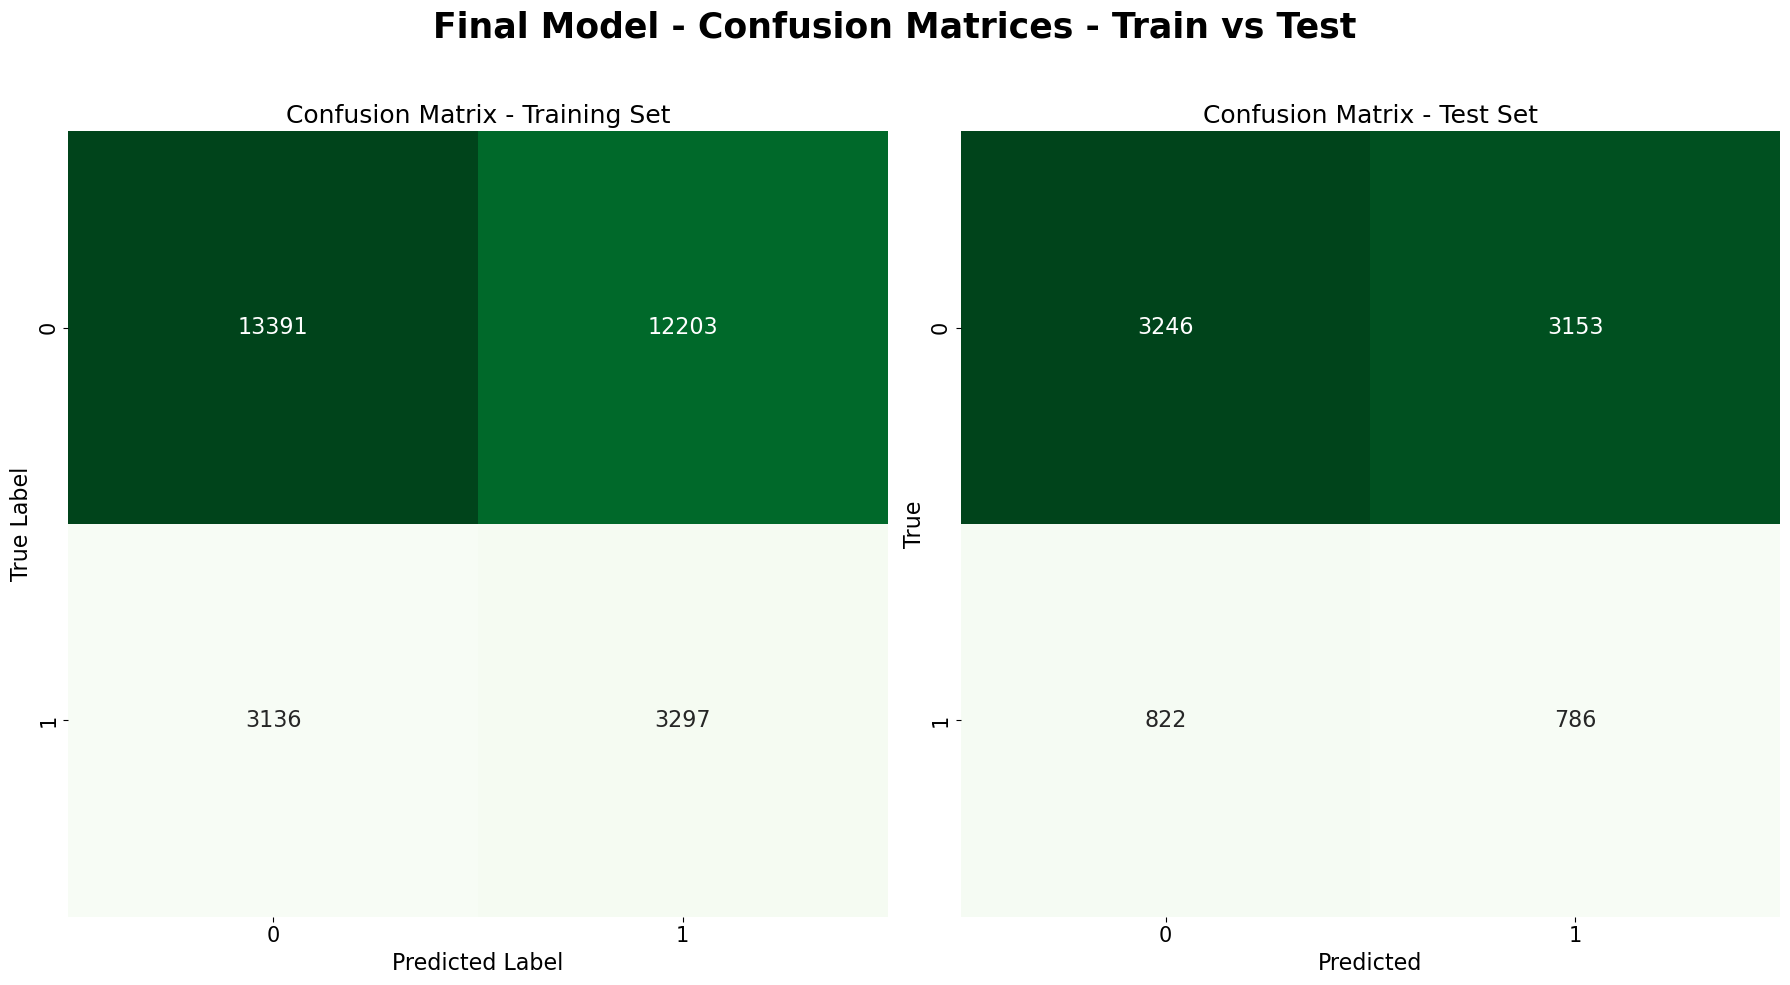

In [528]:
# Confusion matrices for training and test sets
cm_final_train = confusion_matrix(y_train, y_pred_train_m3)
cm_final_test  = confusion_matrix(y_test, y_pred_final_m3)

# Plot side-by-side
# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

# Font sizes
TITLE_FS = 18
AXIS_LABEL_FS = 16
TICK_LABEL_FS = 15
ANNOT_FS = 16

# Training confusion matrix
sns.heatmap(
    cm_final_train,
    annot=True,
    fmt='d',
    cmap='Greens',
    cbar=False,
    annot_kws={'size': ANNOT_FS},
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix - Training Set', fontsize=TITLE_FS)
axes[0].set_xlabel('Predicted Label', fontsize=AXIS_LABEL_FS)
axes[0].set_ylabel('True Label', fontsize=AXIS_LABEL_FS)
axes[0].tick_params(axis='both', labelsize=TICK_LABEL_FS)

# Test confusion matrix
sns.heatmap(
    cm_final_test,
    annot=True,
    fmt='d',
    cmap='Greens',
    cbar=False,
    annot_kws={'size': ANNOT_FS},
    ax=axes[1]
)
axes[1].set_title('Confusion Matrix - Test Set', fontsize=TITLE_FS)
axes[1].set_xlabel('Predicted', fontsize=AXIS_LABEL_FS)
axes[1].set_ylabel('True', fontsize=AXIS_LABEL_FS)
axes[1].tick_params(axis='both', labelsize=TICK_LABEL_FS)

# Suptitle
plt.suptitle(
    'Final Model - Confusion Matrices - Train vs Test',
    fontsize=25,
    fontweight='bold'
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    '26 Confusion_Matrix_Final_Train_Test.png',
    dpi=500,
    bbox_inches='tight'
)
plt.show()


#### PR Curves on both sets

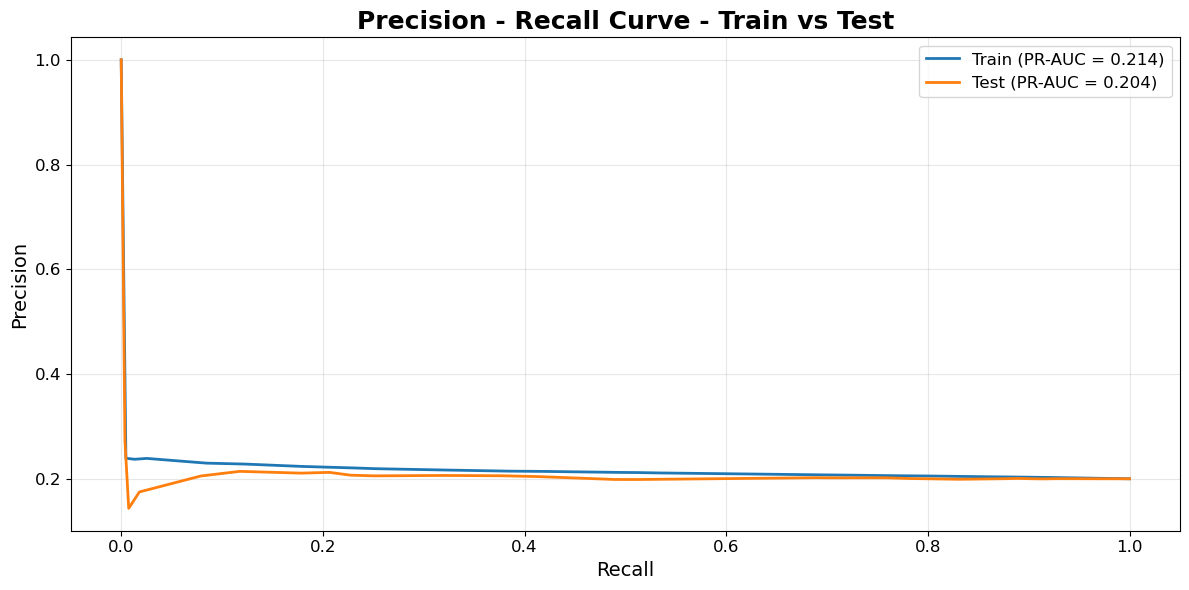

In [470]:
# Training PR curve 
precision_train, recall_train, _ = precision_recall_curve(y_train, y_pred_proba_train_m3)
pr_auc_train = average_precision_score(y_train, y_pred_proba_train_m3)

# Test PR curve
precision_test, recall_test, _ = precision_recall_curve(y_test, y_pred_proba_final_m3)
pr_auc_test = average_precision_score(y_test, y_pred_proba_final_m3)

# Plot both PR curves
plt.figure(figsize=(12, 6))

plt.plot(recall_train, precision_train, linewidth=2, label=f"Train (PR-AUC = {pr_auc_train:.3f})")
plt.plot(recall_test, precision_test, linewidth=2, label=f"Test (PR-AUC = {pr_auc_test:.3f})")

plt.title('Precision - Recall Curve - Train vs Test', fontsize=18, fontweight='bold')
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)

# Tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

plt.tight_layout()
plt.savefig('27 PR_Curve_Train_Test.png', dpi=500, bbox_inches='tight')
plt.show()

#### SHAP

In [410]:
# Compute SHAP values
explainer_final = shap.TreeExplainer(final_m3)
shap_values_train = explainer_final.shap_values(X_train_demo)
shap_values_test = explainer_final.shap_values(X_test_demo)

In [411]:
shap_values_train

array([[-0.01162047, -0.00666952, -0.0266324 ],
       [-0.00477868,  0.00314778, -0.00425867],
       [-0.0026507 , -0.00027405,  0.0098929 ],
       ...,
       [-0.01886762, -0.00074705, -0.01820819],
       [-0.00477868,  0.00314778, -0.00425867],
       [ 0.00227729,  0.00039333,  0.00306431]], dtype=float32)

In [412]:
shap_values_test

array([[-0.01245783, -0.00483725, -0.00362066],
       [-0.00847014,  0.00344948, -0.00086891],
       [-0.01245783, -0.00483725, -0.00362066],
       ...,
       [ 0.00227729,  0.00039333,  0.00306431],
       [ 0.01962521,  0.00795155,  0.01331241],
       [ 0.01754644,  0.00481854, -0.00657389]], dtype=float32)

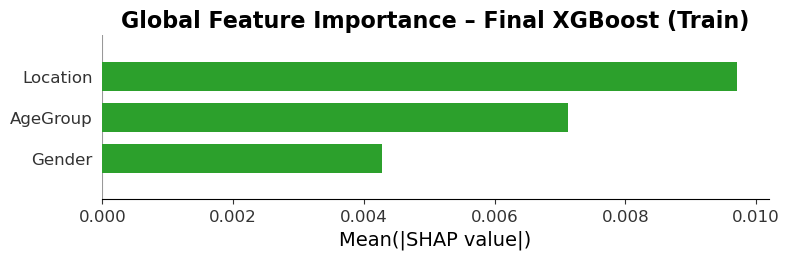

In [466]:
# Training SHAP Global Importance
plt.figure(figsize=(18, 10))

shap.summary_plot(
    shap_values_train,
    X_train_demo,
    plot_type='bar',
    color='#2ca02c',
    show=False
)

plt.title(
    'Global Feature Importance – Final XGBoost (Train)',
    fontsize=16,
    fontweight='bold'
)

plt.xlabel('Mean(|SHAP value|)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig(
    '28a_SHAP_Global_Importance_XGBoost_Train.png',
    dpi=500
)
plt.show()

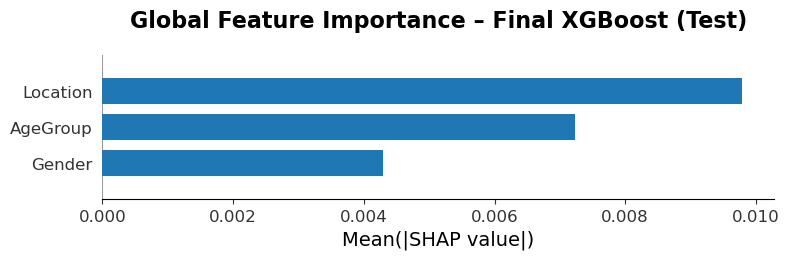

In [468]:
# Test SHAP Global Importance
plt.figure(figsize=(18, 10))

shap.summary_plot(
    shap_values_test,
    X_test_demo,
    plot_type='bar',
    color='#1f77b4',
    show=False
)

plt.title(
    'Global Feature Importance – Final XGBoost (Test)',
    fontsize=16,
    fontweight='bold',
    pad=20
)

plt.xlabel('Mean(|SHAP value|)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(
    '28b_SHAP_Global_Importance_XGBoost_Test.png',
    dpi=500
)
plt.show()


# 7. Sensitive Attribute Performance Review

## Pre-training: Identify disparities

### Early Inspection

In [472]:
# Distribution of age group
print(data_engineer.groupby('AgeGroup')['InGamePurchases'].value_counts(normalize=True).unstack())

InGamePurchases         0         1
AgeGroup                           
Teen             0.795455  0.204545
Young Adult      0.803258  0.196742
Adult            0.798678  0.201322
Mid-Age          0.796529  0.203471
Mature           0.801952  0.198048


<div class="alert alert-info">Name of agegroup as number</div>

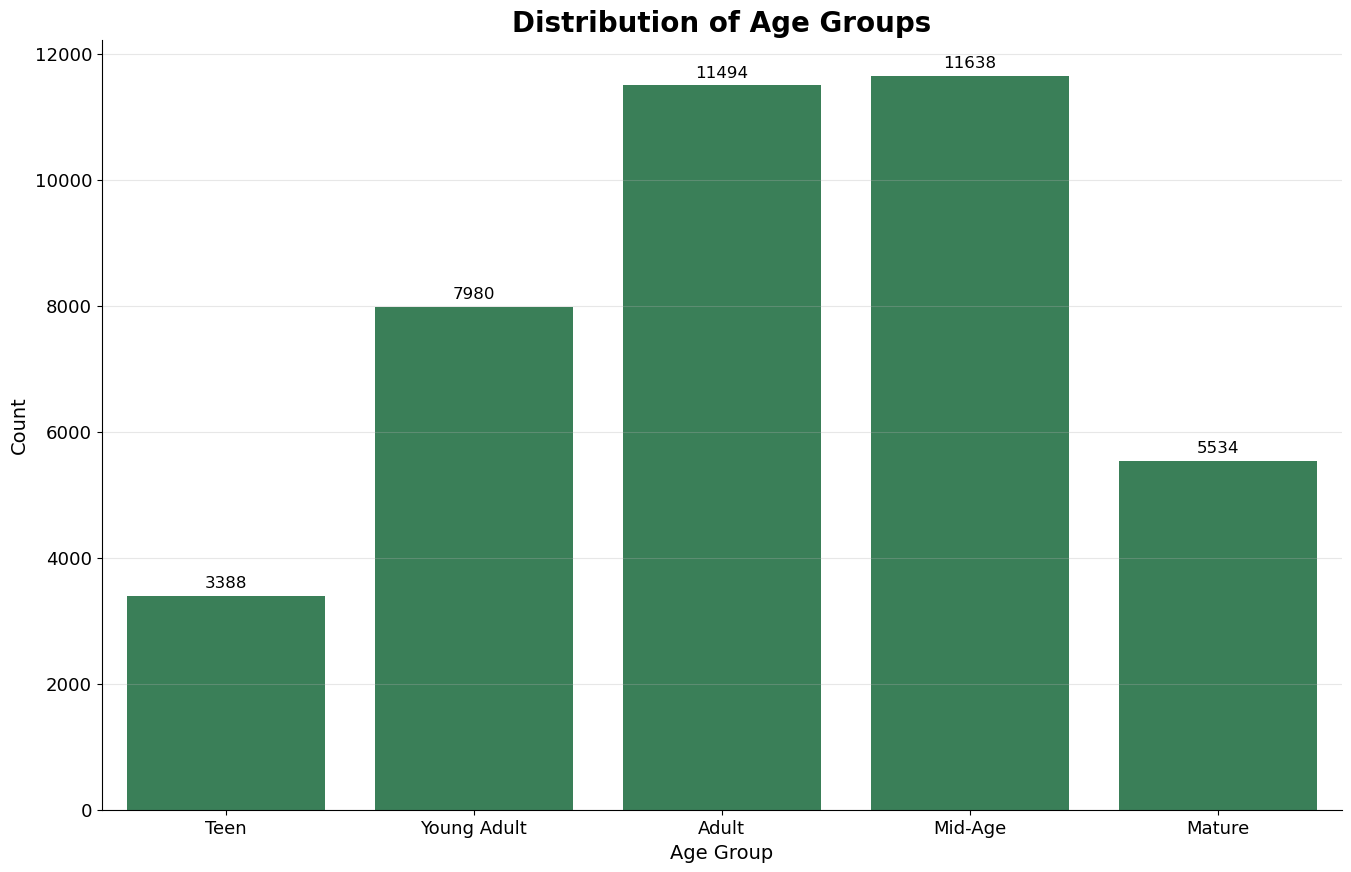

In [522]:
plt.figure(figsize=(16, 10))

ax = sns.countplot(
    data=data_engineer,
    x='AgeGroup',
    color='seagreen'
)

# Title & axis titles
plt.title('Distribution of Age Groups', fontsize=20, fontweight='bold')
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Tick labels 
ax.tick_params(axis='both', labelsize=13)

# Grid 
plt.grid(axis='y', alpha=0.3)

#  Add count labels on top of each bar 
for container in ax.containers:
    ax.bar_label(
        container,
        fmt='%d',
        label_type='edge',
        padding=4,
        fontsize=12       # ⬅️ number above bars
    )

sns.despine(top=True, right=True)

plt.savefig(
    '31 Distribution of Age Groups.png',
    dpi=500,
    bbox_inches='tight'
)
plt.show()


<div class="alert alert-info">Name of agegroup as number</div>

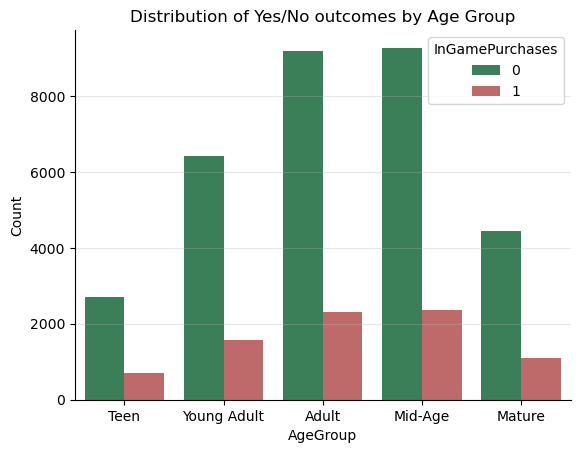

In [413]:
# Visualize disparities
sns.countplot(data=data_engineer, x='AgeGroup', hue='InGamePurchases', palette=['seagreen', 'indianred'])
plt.title('Distribution of Yes/No outcomes by Age Group')
plt.xlabel('AgeGroup')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.3)
sns.despine(top=True, right=True)
plt.savefig('32 Distribution of Yes-No outcomes by Age Group', dpi=300, bbox_inches='tight')
plt.show()

### Before reweighting - Compute TPR, FPR, and PR-AUC

In [489]:
# Combine y train predictions, and probabilities with training data
X_train_all = X_train_demo.copy()
X_train_all['True'] = y_train
X_train_all['Pred'] = y_pred_train_m3
X_train_all['Prob'] = y_pred_proba_train_m3

In [491]:
# Combine y test predictions, and probabilities with test data
X_test_all = X_test_demo.copy()
X_test_all['True'] = y_test
X_test_all['Pred'] = y_pred_final_m3
X_test_all['Prob'] = y_pred_proba_final_m3

In [493]:
metrics_agegroup_before_reweight = []

for group, data in X_test_all.groupby('AgeGroup'):
    y_true = data['True']
    y_pred = data['Pred']
    y_prob = data['Prob']

    # Confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Metrics
    tpr = tp / (tp + fn)    
    fpr = fp / (fp + tn)
    pr_auc = average_precision_score(y_true, y_prob)

    metrics_agegroup_before_reweight.append({
        'AgeGroup': group,
        'TPR': round(tpr, 4),
        'FPR': round(fpr, 4),
        'PR_AUC': round(pr_auc, 4)
    })

# Convert to DataFrame
metrics_agegroup_before_reweight = pd.DataFrame(metrics_agegroup_before_reweight)

print('Model Performance by Age Group - Before Reweighting')
print(metrics_agegroup_before_reweight)

Model Performance by Age Group - Before Reweighting
   AgeGroup     TPR     FPR  PR_AUC
0         0  0.4113  0.3937  0.2147
1         1  0.4103  0.4240  0.1867
2         2  0.5687  0.5932  0.2066
3         3  0.6316  0.6541  0.1937
4         4  0.4756  0.4729  0.2059


### Compute Fairness Metrics 

In [496]:
tpr_before_reweight = metrics_agegroup_before_reweight['TPR'].values
fpr_before_reweight = metrics_agegroup_before_reweight['FPR'].values

# Equal Opportunity Gap (TPR gap)
equal_opportunity_gap_before_reweight = round(max(tpr_before_reweight) - min(tpr_before_reweight), 4)

# FPR Gap
fpr_gap_before_reweight = round(max(fpr_before_reweight) - min(fpr_before_reweight), 4)

# Equalized Odds Gap = max(TPR gap, FPR gap)
equalized_odds_gap_before_reweight = round(max(equal_opportunity_gap_before_reweight, fpr_gap_before_reweight), 4)

print('\nFairness Metrics - Before Reweighting:')
print('Equal Opportunity Gap:', equal_opportunity_gap_before_reweight)
print('Equalized Odds Gap:', equalized_odds_gap_before_reweight)


Fairness Metrics - Before Reweighting:
Equal Opportunity Gap: 0.2213
Equalized Odds Gap: 0.2604


### Before reweighting - TPR and FPR for subgroup based on favored group

but the favored group is group 3 with highest TPR but also highest FPR

In [500]:
# Choose preferred group based on TPR
favored_before_reweight = metrics_agegroup_before_reweight.loc[
    metrics_agegroup_before_reweight['TPR'].idxmax(), 'AgeGroup'
]

print('Favored Group (Highest TPR) before reweighting:', favored_before_reweight)

Favored Group (Highest TPR) before reweighting: 3


In [502]:
# Get the TPR and FPR of favored group
favored_tpr_before_reweight = metrics_agegroup_before_reweight.loc[
    metrics_agegroup_before_reweight['AgeGroup'] == favored_before_reweight, 'TPR'
].values[0]

favored_fpr_before_reweight = metrics_agegroup_before_reweight.loc[
    metrics_agegroup_before_reweight['AgeGroup'] == favored_before_reweight, 'FPR'
].values[0]

In [504]:
favored_tpr_before_reweight

0.6316

In [506]:
favored_fpr_before_reweight

0.6541

In [508]:
# Compute TPR Gap and FPR gap
metrics_agegroup_before_reweight['TPR_Gap_vs_Favored'] =round(
    favored_tpr_before_reweight - metrics_agegroup_before_reweight['TPR'], 4)

metrics_agegroup_before_reweight['FPR_Gap_vs_Favored'] = round(
    metrics_agegroup_before_reweight['FPR'] - favored_fpr_before_reweight, 4)

In [510]:
metrics_agegroup_before_reweight

,AgeGroup,TPR,FPR,PR_AUC,TPR_Gap_vs_Favored,FPR_Gap_vs_Favored
0,0,0.4113,0.3937,0.2147,0.2203,-0.2604
1,1,0.4103,0.4240,0.1867,0.2213,-0.2301
2,2,0.5687,0.5932,0.2066,0.0629,-0.0609
3,3,0.6316,0.6541,0.1937,0.0000,0.0000
4,4,0.4756,0.4729,0.2059,0.1560,-0.1812


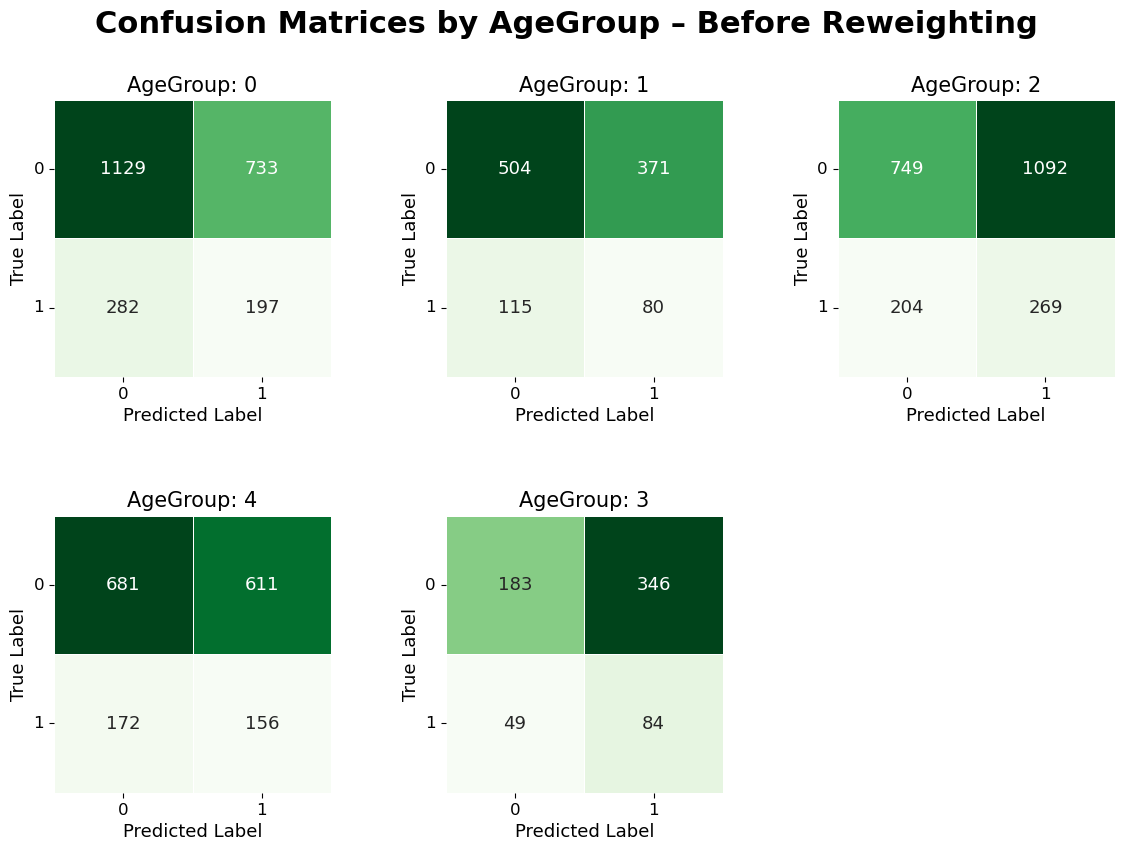

In [520]:
age_groups = X_test_all['AgeGroup'].unique()

# Prepare 2x3 layout (bigger figure)
fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

# Font sizes
SUBTITLE_FS = 15
AXIS_LABEL_FS = 13
TICK_LABEL_FS = 12
ANNOT_FS = 13

for i, group in enumerate(age_groups):
    data = X_test_all[X_test_all['AgeGroup'] == group]
    y_true = data['True']
    y_pred = data['Pred']

    cm_agegroup_before_reweight = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        cm_agegroup_before_reweight,
        annot=True,
        fmt='d',
        cmap='Greens',
        cbar=False,
        square=True,
        linewidths=0.5,
        annot_kws={'size': ANNOT_FS}, 
        ax=axes[i]
    )

    # Titles & labels
    axes[i].set_title(f'AgeGroup: {group}', fontsize=SUBTITLE_FS)
    axes[i].set_xlabel('Predicted Label', fontsize=AXIS_LABEL_FS)
    axes[i].set_ylabel('True Label', fontsize=AXIS_LABEL_FS)

    # Tick labels
    axes[i].set_xticklabels(['0', '1'], fontsize=TICK_LABEL_FS)
    axes[i].set_yticklabels(['0', '1'], fontsize=TICK_LABEL_FS, rotation=0)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


fig.suptitle(
    'Confusion Matrices by AgeGroup – Before Reweighting',
    fontsize=22,
    fontweight='bold',
    y=0.98
)

plt.subplots_adjust(
    hspace=0.5,   
    wspace=0.3  
)

plt.savefig(
    '33 Confusion Matrices by AgeGroup_Before Reweighting.png',
    dpi=500
)
plt.show()


## Apply subgroup-reweighting on the model

In [443]:
best_params_m3

{'gamma': 2,
 'learning_rate': 0.001,
 'max_depth': 7,
 'n_estimators': 300,
 'reg_lambda': 2,
 'scale_pos_weight': 3.978548111301104}

### Create balanced weights

In [445]:
# Compute group frequencies from training data
group_counts_train = X_train_all['AgeGroup'].value_counts()
num_groups = group_counts_train.shape[0]
total_train = len(X_train_all)

# Balanced weights
group_weights_train = total_train / (num_groups * group_counts_train)

print('Computed Weights per AgeGroup:')
print(group_weights_train)

# Assign weights to each training row
sample_weights_train = X_train_all['AgeGroup'].map(group_weights_train).values

Computed Weights per AgeGroup:
AgeGroup
2    0.686980
0    0.699814
4    1.007138
1    1.434901
3    2.349743
Name: count, dtype: float64


### Train the models with weights

In [447]:
# Train the model with reweighting
final_m3_reweighted = XGBClassifier(**best_params_m3, random_state=23)

final_m3_reweighted.fit(
    X_train_demo,
    y_train,
    sample_weight = sample_weights_train
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=23, ...)

### Predict on the test set with reweighted model

In [449]:
# Predictions
y_pred_reweighted = final_m3_reweighted.predict(X_test_demo)
y_prob_reweighted = final_m3_reweighted.predict_proba(X_test_demo)[:, 1]

In [451]:
# Store to X_test_all
X_test_all['Pred_reweighted'] = y_pred_reweighted
X_test_all['Prob_reweighted'] = y_prob_reweighted

In [454]:
X_test_all.head(5)

,Location,Gender,AgeGroup,True,Pred,Prob,Pred_reweighted,Prob_reweighted
24140,3,0,0,0,0,0.494771,0,0.497856
17129,3,1,1,0,0,0.498528,0,0.497856
4776,3,0,0,0,0,0.494771,0,0.497856
35035,1,1,2,0,1,0.501434,1,0.501656
3297,1,1,4,0,0,0.494709,0,0.494709


### Reweighted - Compute TPR, FPR, and PR-AUC - Test set

In [457]:
metrics_agegroup_reweighted = []

for group, data in X_test_all.groupby('AgeGroup'):
    y_true = data['True']
    y_pred = data['Pred_reweighted']
    y_prob = data['Prob_reweighted']

    # Confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Metrics
    tpr = tp / (tp + fn)    
    fpr = fp / (fp + tn)
    pr_auc = average_precision_score(y_true, y_prob)

    metrics_agegroup_reweighted.append({
        'AgeGroup': group,
        'TPR': round(tpr, 4),
        'FPR': round(fpr, 4),
        'PR_AUC': round(pr_auc, 4)
    })

# Convert to DataFrame
metrics_agegroup_reweighted = pd.DataFrame(metrics_agegroup_reweighted)

print('Model Performance by Age Group - Reweighted')
print(metrics_agegroup_reweighted)

Model Performance by Age Group - Reweighted
   AgeGroup     TPR     FPR  PR_AUC
0         0  0.4113  0.3937  0.2094
1         1  0.4103  0.4240  0.1830
2         2  0.4165  0.4367  0.2052
3         3  0.7143  0.7240  0.1875
4         4  0.4756  0.4729  0.2063


### Reweighted - Compute Fairness Metrics 

In [460]:
tpr_reweighted = metrics_agegroup_reweighted['TPR'].values
fpr_reweighted = metrics_agegroup_reweighted['FPR'].values

# Equal Opportunity Gap (TPR gap)
equal_opportunity_gap_reweighted = round(max(tpr_reweighted) - min(tpr_reweighted), 4)

# FPR Gap
fpr_gap_reweighted = round(max(fpr_reweighted) - min(fpr_reweighted), 4)

# Equalized Odds Gap = max(TPR gap, FPR gap)
equalized_odds_gap_reweighted = round(max(equal_opportunity_gap_reweighted, fpr_gap_reweighted), 4)

print('\nFairness Metrics - Reweighted:')
print('Equal Opportunity Gap:', equal_opportunity_gap_reweighted)
print('Equalized Odds Gap:', equalized_odds_gap_reweighted)


Fairness Metrics - Reweighted:
Equal Opportunity Gap: 0.304
Equalized Odds Gap: 0.3303


### Reweighted - TPR and FPR for subgroup based on favored group

In [463]:
# Choose preferred group based on TPR - reweighted
favored_reweighted = metrics_agegroup_reweighted.loc[
    metrics_agegroup_reweighted['TPR'].idxmax(), 'AgeGroup'
]

print('Favored Group (Highest TPR) before reweighting:', favored_reweighted)

Favored Group (Highest TPR) before reweighting: 3


In [465]:
# Get the TPR and FPR of favored group - reweighted
favored_tpr_reweighted = metrics_agegroup_reweighted.loc[
    metrics_agegroup_reweighted['AgeGroup'] == favored_reweighted, 'TPR'
].values[0]

favored_fpr_reweighted = metrics_agegroup_reweighted.loc[
    metrics_agegroup_reweighted['AgeGroup'] == favored_reweighted, 'FPR'
].values[0]

In [467]:
# Compute TPR Gap and FPR gap
metrics_agegroup_reweighted['TPR_Gap_vs_Favored'] =round(
    favored_tpr_reweighted - metrics_agegroup_reweighted['TPR'], 4)

metrics_agegroup_reweighted['FPR_Gap_vs_Favored'] = round(
    metrics_agegroup_reweighted['FPR'] - favored_fpr_reweighted, 4)
metrics_agegroup_reweighted

,AgeGroup,TPR,FPR,PR_AUC,TPR_Gap_vs_Favored,FPR_Gap_vs_Favored
0,0,0.4113,0.3937,0.2094,0.3030,-0.3303
1,1,0.4103,0.4240,0.1830,0.3040,-0.3000
2,2,0.4165,0.4367,0.2052,0.2978,-0.2873
3,3,0.7143,0.7240,0.1875,0.0000,0.0000
4,4,0.4756,0.4729,0.2063,0.2387,-0.2511


In [469]:
X_test_all.head(5)

,Location,Gender,AgeGroup,True,Pred,Prob,Pred_reweighted,Prob_reweighted
24140,3,0,0,0,0,0.494771,0,0.497856
17129,3,1,1,0,0,0.498528,0,0.497856
4776,3,0,0,0,0,0.494771,0,0.497856
35035,1,1,2,0,1,0.501434,1,0.501656
3297,1,1,4,0,0,0.494709,0,0.494709


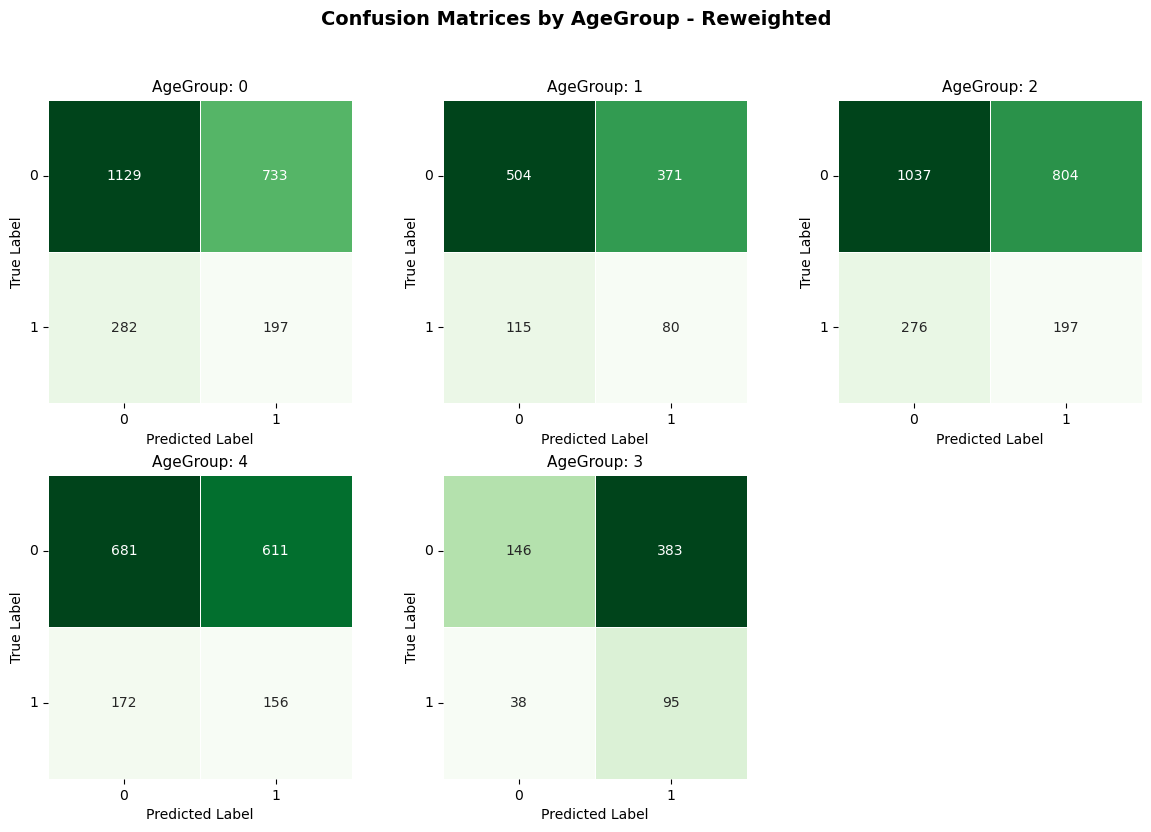

In [471]:
# Prepare 2x3 layout
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for i, group in enumerate(age_groups):
    data = X_test_all[X_test_all['AgeGroup'] == group]
    y_true = data['True']
    y_pred = data['Pred_reweighted']

    cm_agegroup_reweighted = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm_agegroup_reweighted, 
        annot=True, fmt='d', cmap='Greens', cbar=False, 
        square=True, linewidths=0.5, ax=axes[i]
    )

    axes[i].set_title(f'AgeGroup: {group}', fontsize=11)
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_xticklabels(['0', '1'])
    axes[i].set_yticklabels(['0', '1'], rotation=0)

# Remove the unused subplot (6th cell)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Confusion Matrices by AgeGroup - Reweighted', fontsize=14, fontweight='bold', y=1.03)
plt.savefig('34 Confusion Matrices by AgeGroup_Reweighted', bbox_inches='tight')
plt.tight_layout()
plt.show()

## Threshold optimization (No retraining)

### Reweighted - Compute TPR, FPR, and PR-AUC - Training set

In [475]:
X_train_all.head(5)

,Location,Gender,AgeGroup,True,Pred,Prob
6328,0,1,0,1,0,0.488771
31028,3,1,0,0,0,0.498528
28807,3,0,2,0,1,0.501742
1534,3,1,1,0,0,0.498528
1994,3,1,2,1,0,0.498528


In [477]:
# Predictions from the reweighted model on training set
y_pred_reweighted_train = final_m3_reweighted.predict(X_train_demo)
y_prob_reweighted_train = final_m3_reweighted.predict_proba(X_train_demo)[:, 1]

# Store in X_train_all
X_train_all['Pred_reweighted_train'] = y_pred_reweighted_train
X_train_all['Prob_reweighted_train'] = y_prob_reweighted_train


In [479]:
X_train_all.head(5)

,Location,Gender,AgeGroup,True,Pred,Prob,Pred_reweighted_train,Prob_reweighted_train
6328,0,1,0,1,0,0.488771,0,0.488792
31028,3,1,0,0,0,0.498528,0,0.497856
28807,3,0,2,0,1,0.501742,0,0.497856
1534,3,1,1,0,0,0.498528,0,0.497856
1994,3,1,2,1,0,0.498528,0,0.497856


In [481]:
metrics_agegroup_reweighted_train = []

for group, data in X_train_all.groupby('AgeGroup'):
    y_true = data['True']
    y_pred = data['Pred_reweighted_train']
    y_prob = data['Prob_reweighted_train']

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    pr_auc = average_precision_score(y_true, y_prob)

    metrics_agegroup_reweighted_train.append({
        'AgeGroup': group,
        'TPR': round(tpr, 4),
        'FPR': round(fpr, 4),
        'PR_AUC': round(pr_auc, 4)
    })

metrics_agegroup_reweighted_train = pd.DataFrame(metrics_agegroup_reweighted_train)
print('Reweighted stage training metrics:')
print(metrics_agegroup_reweighted_train)


Reweighted stage training metrics:
   AgeGroup     TPR     FPR  PR_AUC
0         0  0.4125  0.3744  0.2096
1         1  0.4273  0.4008  0.2093
2         2  0.4338  0.4138  0.2090
3         3  0.7411  0.6930  0.2206
4         4  0.5113  0.4654  0.2060


### Compute target TPR
- choose the median since median is not affected by extreme values

In [484]:
target_tpr = metrics_agegroup_reweighted_train['TPR'].median()
print('Target TPR for threshold adjustment:', target_tpr)

Target TPR for threshold adjustment: 0.4338


### Compute Threshold for Each Subgroup

In [487]:
thresholds_subgroup = {}

for group, data in X_train_all.groupby('AgeGroup'):

    y_true = data['True'].values
    y_prob = data['Prob_reweighted_train'].values

    # Compute ROC
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    
    # Interpolate threshold for target TPR
    best_threshold = float(np.interp(target_tpr, tpr, thr))

    thresholds_subgroup[group] = best_threshold

print('\nCorrected optimal thresholds per AgeGroup:')
for g, t in thresholds_subgroup.items():
    print(f"AgeGroup {g}: threshold = {t:.3f}")


Corrected optimal thresholds per AgeGroup:
AgeGroup 0: threshold = 0.502
AgeGroup 1: threshold = 0.501
AgeGroup 2: threshold = 0.502
AgeGroup 3: threshold = 0.508
AgeGroup 4: threshold = 0.503


### Apply Threshold to X_test_all

In [490]:
X_test_all.head(5)

,Location,Gender,AgeGroup,True,Pred,Prob,Pred_reweighted,Prob_reweighted
24140,3,0,0,0,0,0.494771,0,0.497856
17129,3,1,1,0,0,0.498528,0,0.497856
4776,3,0,0,0,0,0.494771,0,0.497856
35035,1,1,2,0,1,0.501434,1,0.501656
3297,1,1,4,0,0,0.494709,0,0.494709


In [492]:
# Apply thresholds to test set predictions
y_pred_threshold = []

for idx, row in X_test_all.iterrows():
    group = row['AgeGroup']
    prob = row['Prob_reweighted']
    thr = thresholds_subgroup[group]
    y_pred_threshold.append(1 if prob >= thr else 0) # compare with prediction after rew and before thres --> above thres is positive otherwise negative

X_test_all['Pred_stage3'] = y_pred_threshold


In [494]:
X_test_all.head(10)

,Location,Gender,AgeGroup,True,Pred,Prob,Pred_reweighted,Prob_reweighted,Pred_stage3
24140,3,0,0,0,0,0.494771,0,0.497856,0
17129,3,1,1,0,0,0.498528,0,0.497856,0
4776,3,0,0,0,0,0.494771,0,0.497856,0
35035,1,1,2,0,1,0.501434,1,0.501656,1
3297,1,1,4,0,0,0.494709,0,0.494709,0
3749,1,1,0,0,1,0.506792,1,0.507121,1
31657,3,1,4,0,1,0.502444,1,0.503164,0
4898,1,1,1,0,1,0.501434,1,0.501656,1
20608,3,1,4,0,1,0.502444,1,0.503164,0
3757,3,1,2,0,0,0.498528,0,0.497856,0


### Threshold - Compute TPR, FPR, and PR-AUC - Test set

In [497]:
metrics_agegroup_thres = []

for group, data in X_test_all.groupby('AgeGroup'):

    y_true = data['True']
    y_pred = data['Pred_stage3']
    y_prob = data['Prob_reweighted']

    # Confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    # Metrics
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn) 
    pr_auc = average_precision_score(y_true, y_prob)

    metrics_agegroup_thres.append({
        'AgeGroup': group,
        'TPR': round(tpr, 4),
        'FPR': round(fpr, 4),
        'PR_AUC': round(pr_auc, 4)
    })

metrics_agegroup_thres = pd.DataFrame(metrics_agegroup_thres)

print('\nThreshold - Model Performance by Age Group:')
print(metrics_agegroup_thres)


Threshold - Model Performance by Age Group:
   AgeGroup     TPR     FPR  PR_AUC
0         0  0.4113  0.3937  0.2094
1         1  0.4103  0.4240  0.1830
2         2  0.4165  0.4367  0.2052
3         3  0.2180  0.2571  0.1875
4         4  0.2409  0.2531  0.2063


### Threshold - Compute Fairness Metrics 

In [500]:
tpr_thres = metrics_agegroup_thres['TPR'].values
fpr_thres = metrics_agegroup_thres['FPR'].values

# Equal Opportunity: TPR gap
equal_opportunity_gap_thres = round(max(tpr_thres) - min(tpr_thres), 4)

# FPR gap
fpr_gap_thres = round(max(fpr_thres) - min(fpr_thres), 4)

# Equalized Odds
equalized_odds_gap_thres = round(max(equal_opportunity_gap_thres, fpr_gap_thres), 4)

print('\nFairness Metrics – Threshold Optimization:')
print('Equal Opportunity Gap:', equal_opportunity_gap_thres)
print('Equalized Odds Gap:', equalized_odds_gap_thres)


Fairness Metrics – Threshold Optimization:
Equal Opportunity Gap: 0.1985
Equalized Odds Gap: 0.1985


### Threshold - TPR and FPR for subgroup based on favored group

In [503]:
print (favored_reweighted.dtype)
print (favored_reweighted)

int64
3


In [505]:
# Get the TPR and FPR of favored group (keep the favored group as before threshold since this is favored by the model)
favored_tpr_thres = metrics_agegroup_thres.loc[
    metrics_agegroup_thres['AgeGroup'] == favored_reweighted, 'TPR'
].values[0]

favored_fpr_thres = metrics_agegroup_thres.loc[
    metrics_agegroup_thres['AgeGroup'] == favored_reweighted, 'FPR'
].values[0]

In [507]:
favored_tpr_thres

0.218

In [509]:
# Compute TPR Gap and FPR gap
metrics_agegroup_thres['TPR_Gap_vs_Favored'] =round(
    favored_tpr_thres - metrics_agegroup_thres['TPR'], 4)

metrics_agegroup_thres['FPR_Gap_vs_Favored'] = round(
    metrics_agegroup_thres['FPR'] - favored_fpr_thres, 4)
metrics_agegroup_thres

,AgeGroup,TPR,FPR,PR_AUC,TPR_Gap_vs_Favored,FPR_Gap_vs_Favored
0,0,0.4113,0.3937,0.2094,-0.1933,0.1366
1,1,0.4103,0.4240,0.1830,-0.1923,0.1669
2,2,0.4165,0.4367,0.2052,-0.1985,0.1796
3,3,0.2180,0.2571,0.1875,0.0000,0.0000
4,4,0.2409,0.2531,0.2063,-0.0229,-0.0040


## Fairness Metrics Comparison

In [512]:
fairness_comparison = pd.DataFrame({
    'Stage': ['Before Reweighting', 'Reweighted', 'Threshold Adjustment'],
    'Equal_Opportunity_Gap': [
        equal_opportunity_gap_before_reweight,
        equal_opportunity_gap_reweighted,
        equal_opportunity_gap_thres
    ],
    'FPR_Gap': [
        fpr_gap_before_reweight,
        fpr_gap_reweighted,
        fpr_gap_thres
    ],
    'Equalized_Odds_Gap': [
        equalized_odds_gap_before_reweight,
        equalized_odds_gap_reweighted,
        equalized_odds_gap_thres
    ]
})

print(fairness_comparison)

                  Stage  Equal_Opportunity_Gap  FPR_Gap  Equalized_Odds_Gap
0    Before Reweighting                 0.2213   0.2604              0.2604
1            Reweighted                 0.3040   0.3303              0.3303
2  Threshold Adjustment                 0.1985   0.1836              0.1985
